## Table of Contents
1. [Introduction](#introduction)
2. [Data loading and cleaning](#data-loading-and-cleaning)
3. [Univariate analysis](#univariate-analysis)
4. [Bivariate analysis](#bivariate-analysis)
5. [A first look at time series](#a-first-look-at-time-series)
6. [ADF tests](#adf-test)
7. [Time series decomposition](#time-series-decomposition)
8. [Auto-SARIMAX model](#auto-sarimax-model)
9. [Univariate Prophet](#univariate-prophet)
10. [Multivariate Prophet](#multivariate-prophet)
    - 10.1 [Changepoints added](#changepoints-added)
11. [Univariate Prophet revisited](#univariate-prophet-revisited)
12. [Improvements](#improvements)
    - 12.1 [Ensembling method](#ensembling-method)
    - 12.2 [Differencing the series](#differencing-the-series)
13. [Multivariate approach](#multivariate-approach)
14. [Vector Error Correction Model (VECM)](#vecm)
14. [LSTM](#lstm)
15. [Neural Prophet](#neural-prophet)
16. [Conclusion](#conclusion)


<a id="introduction" ></a>
# Introduction

In this notebook, I use several methods to predict the mean_temperature for the daily climate time series data. For beginners, I would advise to take a look on my earlier notebook:

https://www.kaggle.com/code/thuongtuandang/arima-prophet-lstm-complete-guide

Here are methods I used in this notebook:

- SARIMAX: Seasonal ARIMA + exogenous variables.
- Prophet:
    - Univariate Prophet 
    - Univariate Prophet + XG Boost on the residuals
    - Univariate Prophet on differencing time series
    - Multivariate Prophet
- VECM
- LSTM
- Neural Prophet: Neural network version of Prophet.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

<a id="data-loading-and-cleaning" ></a>
# Data Loading and Cleaning

In [2]:
df_train = pd.read_csv('data/DailyDelhiClimateTrain.csv')
df_test = pd.read_csv('data/DailyDelhiClimateTest.csv')

In [3]:
df_train.head()

date   meantemp   humidity  wind_speed  meanpressure
0  2013-01-01  10.000000  84.500000    0.000000   1015.666667
1  2013-01-02   7.400000  92.000000    2.980000   1017.800000
2  2013-01-03   7.166667  87.000000    4.633333   1018.666667
3  2013-01-04   8.666667  71.333333    1.233333   1017.166667
4  2013-01-05   6.000000  86.833333    3.700000   1016.500000

In [4]:
df_train.tail()

date   meantemp    humidity  wind_speed  meanpressure
1457  2016-12-28  17.217391   68.043478    3.547826   1015.565217
1458  2016-12-29  15.238095   87.857143    6.000000   1016.904762
1459  2016-12-30  14.095238   89.666667    6.266667   1017.904762
1460  2016-12-31  15.052632   87.000000    7.325000   1016.100000
1461  2017-01-01  10.000000  100.000000    0.000000   1016.000000

In [5]:
df_train.describe()

meantemp     humidity   wind_speed  meanpressure
count  1462.000000  1462.000000  1462.000000   1462.000000
mean     25.495521    60.771702     6.802209   1011.104548
std       7.348103    16.769652     4.561602    180.231668
min       6.000000    13.428571     0.000000     -3.041667
25%      18.857143    50.375000     3.475000   1001.580357
50%      27.714286    62.625000     6.221667   1008.563492
75%      31.305804    72.218750     9.238235   1014.944901
max      38.714286   100.000000    42.220000   7679.333333

In [6]:
df_train.isna().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

In [7]:
df_test.isna().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

In [8]:
df_train['date'] = pd.to_datetime(df_train['date'], format = '%Y-%m-%d')

In [9]:
df_train['day'] = df_train['date'].dt.day
df_train['week'] = df_train['date'].dt.isocalendar().week
df_train['month'] = df_train['date'].dt.month
df_train['year'] = df_train['date'].dt.year

In [10]:
df_train = df_train.rename(columns = {'meantemp': 'mean_temp', 'meanpressure': 'mean_pressure'})

In [11]:
df_train

date  mean_temp    humidity  wind_speed  mean_pressure  day  week  \
0    2013-01-01  10.000000   84.500000    0.000000    1015.666667    1     1   
1    2013-01-02   7.400000   92.000000    2.980000    1017.800000    2     1   
2    2013-01-03   7.166667   87.000000    4.633333    1018.666667    3     1   
3    2013-01-04   8.666667   71.333333    1.233333    1017.166667    4     1   
4    2013-01-05   6.000000   86.833333    3.700000    1016.500000    5     1   
...         ...        ...         ...         ...            ...  ...   ...   
1457 2016-12-28  17.217391   68.043478    3.547826    1015.565217   28    52   
1458 2016-12-29  15.238095   87.857143    6.000000    1016.904762   29    52   
1459 2016-12-30  14.095238   89.666667    6.266667    1017.904762   30    52   
1460 2016-12-31  15.052632   87.000000    7.325000    1016.100000   31    52   
1461 2017-01-01  10.000000  100.000000    0.000000    1016.000000    1    52   

      month  year  
0         1  2013  
1         1  2013  
2         1  2013  
3         1  2013  
4         1  2013  
...     ...   ...  
1457     12  2016  
1458     12  2016  
1459     12  2016  
1460     12  2016  
1461      1  2017  

[1462 rows x 9 columns]

In [12]:
def get_season(month):
    if month in [12, 1, 2]:
        return 3
    if month in [3, 4, 5]:
        return 0
    if month in [6, 7, 8]:
        return 1
    if month in [9, 10, 11]:
        return 2

df_train['season'] = df_train['month'].apply(get_season)
df_train

date  mean_temp    humidity  wind_speed  mean_pressure  day  week  \
0    2013-01-01  10.000000   84.500000    0.000000    1015.666667    1     1   
1    2013-01-02   7.400000   92.000000    2.980000    1017.800000    2     1   
2    2013-01-03   7.166667   87.000000    4.633333    1018.666667    3     1   
3    2013-01-04   8.666667   71.333333    1.233333    1017.166667    4     1   
4    2013-01-05   6.000000   86.833333    3.700000    1016.500000    5     1   
...         ...        ...         ...         ...            ...  ...   ...   
1457 2016-12-28  17.217391   68.043478    3.547826    1015.565217   28    52   
1458 2016-12-29  15.238095   87.857143    6.000000    1016.904762   29    52   
1459 2016-12-30  14.095238   89.666667    6.266667    1017.904762   30    52   
1460 2016-12-31  15.052632   87.000000    7.325000    1016.100000   31    52   
1461 2017-01-01  10.000000  100.000000    0.000000    1016.000000    1    52   

      month  year  season  
0         1  2013       3  
1         1  2013       3  
2         1  2013       3  
3         1  2013       3  
4         1  2013       3  
...     ...   ...     ...  
1457     12  2016       3  
1458     12  2016       3  
1459     12  2016       3  
1460     12  2016       3  
1461      1  2017       3  

[1462 rows x 10 columns]

In [13]:
df_train['year'].value_counts()

year
2016    366
2013    365
2014    365
2015    365
2017      1
Name: count, dtype: int64

In [14]:
df_train['month'].value_counts()

month
1     125
3     124
5     124
7     124
8     124
10    124
12    124
4     120
6     120
9     120
11    120
2     113
Name: count, dtype: int64

<a id="univariate-analysis" ></a>
# Univariate Analysis

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

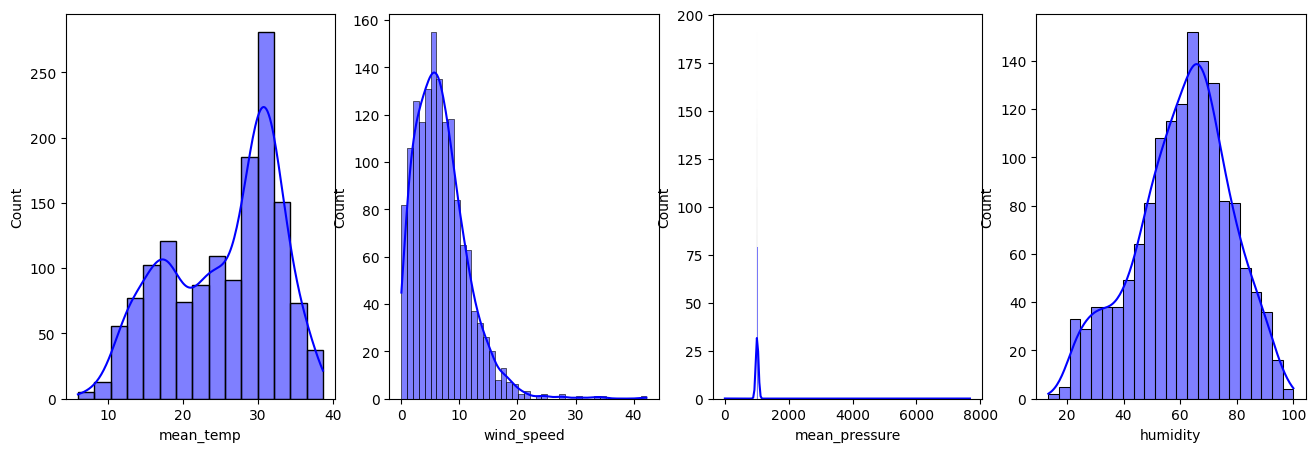

In [16]:
# Histplot of the four features
columns = {'mean_temp', 'humidity', 'wind_speed', 'mean_pressure'}
fig, ax = plt.subplots(1, 4, figsize = (16,5))

for i, col in enumerate(columns):
    sns.histplot(
        data = df_train,
        x = col,
        ax=ax[i],
        kde = True,
        color = 'blue'
    )
plt.show()

Observations:

- mean_temp is bimodal: The two peaks could represent different modes for temperatures in different seasons, such as warmer temperatures in summer and cooler temperatures in winter.

- wind_speed: The wind speed distribution looks right-skewed, meaning there's a longer tail on the right side of the distribution. This could indicate that higher wind speeds are less frequent but do occur.

- humidity: The humidity distribution appears to be roughly normal or bell-shaped, indicating that most of the data falls around the central value, with fewer occurrences of extremely low or high humidity values.

- mean_pressure: The pressure distribution is quite peculiar, as it shows a very sharp peak and a narrow range of values. 

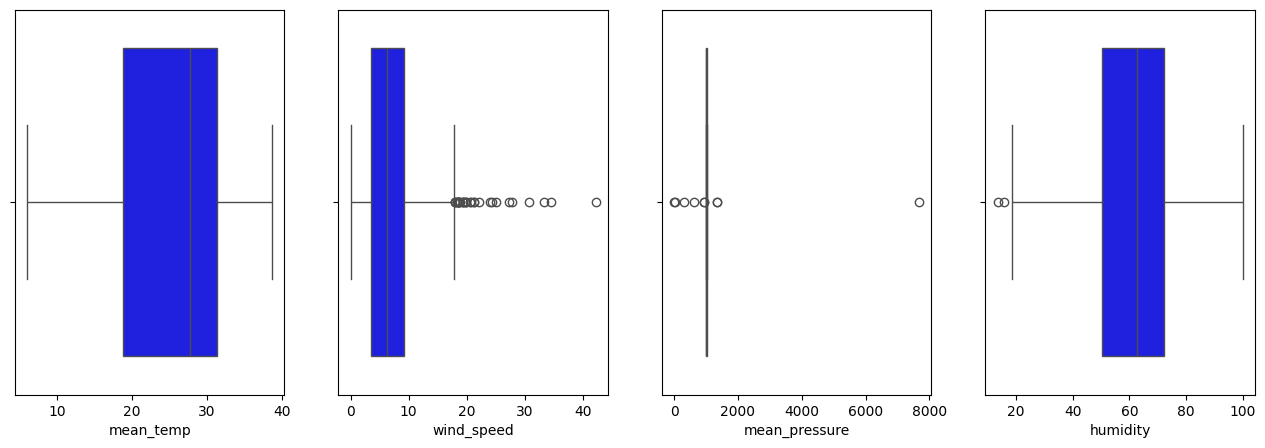

In [17]:
# Boxplot to remove outliers (if there are any)
fig, ax = plt.subplots(1, 4, figsize = (16,5))
for i, col in enumerate(columns): 
    sns.boxplot(
        data = df_train,
        x = col,
        ax = ax[i],
        color = 'blue'
    )
plt.show()

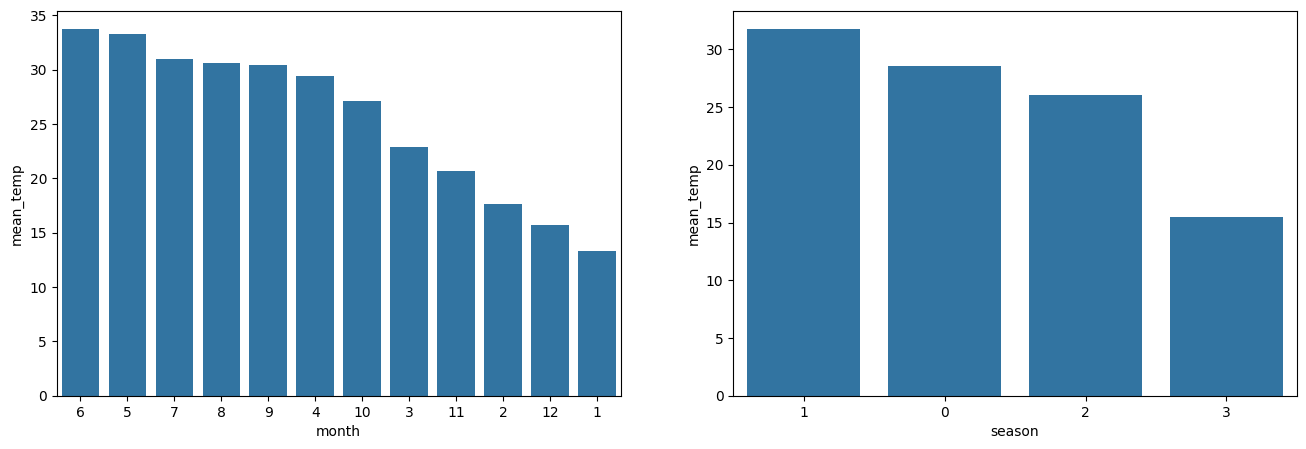

In [18]:
# Mean_temp over seasons and months
index = {'season', 'month'}
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
for i, ind in enumerate(index):
    index_sort = df_train.groupby(ind)['mean_temp'].mean().sort_values(ascending=False).index
    sns.barplot(
        data = df_train,
        x = ind,
        y = 'mean_temp',
        ax = ax[i],
        order = index_sort,
        errorbar = None,
        estimator=np.mean
    )

The mean temperature is high on summer and low on winter.

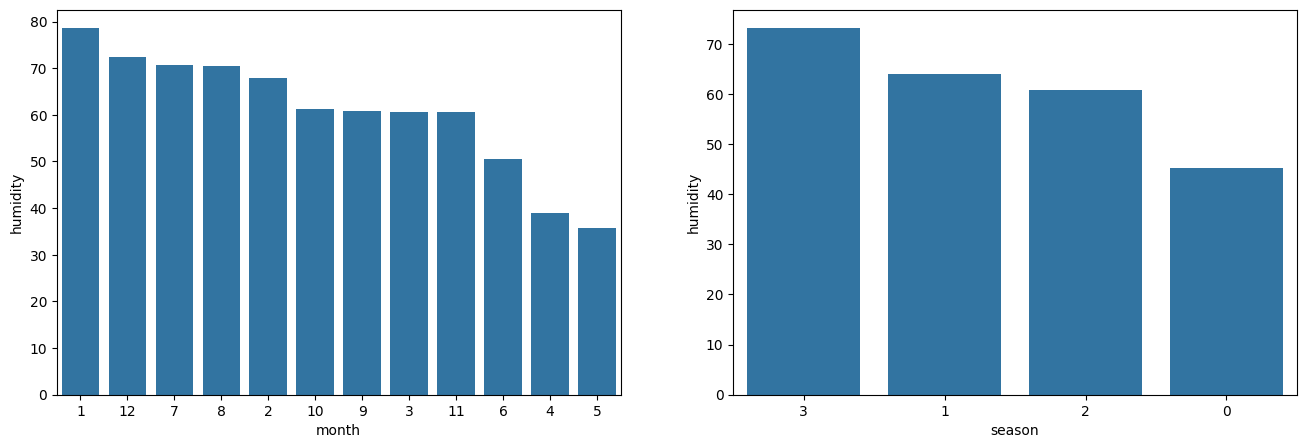

In [19]:
# Humidity over seasons and months
index = {'season', 'month'}
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
for i, ind in enumerate(index):
    index_sort = df_train.groupby(ind)['humidity'].mean().sort_values(ascending=False).index
    sns.barplot(
        data = df_train,
        x = ind,
        y = 'humidity',
        ax = ax[i],
        order = index_sort,
        errorbar = None,
        estimator=np.mean
    )

The humidity is highest on winter, and low on spring.

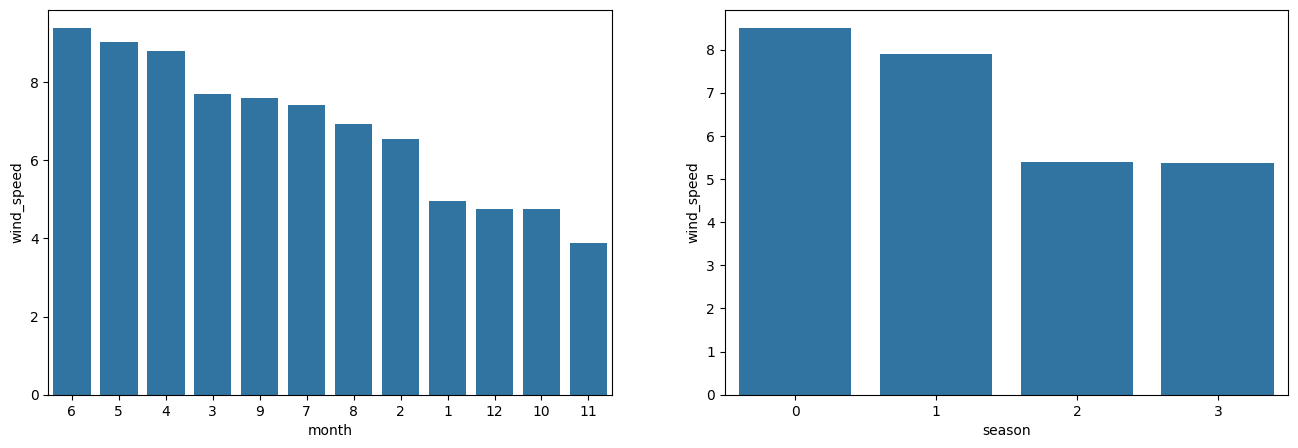

In [20]:
# Wind_speed over seasons and months
index = {'season', 'month'}
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
for i, ind in enumerate(index):
    index_sort = df_train.groupby(ind)['wind_speed'].mean().sort_values(ascending=False).index
    sns.barplot(
        data = df_train,
        x = ind,
        y = 'wind_speed',
        ax = ax[i],
        order = index_sort,
        errorbar = None,
        estimator=np.mean
    )

The wind_speed is high on spring and summer, but low on autumn and winter.

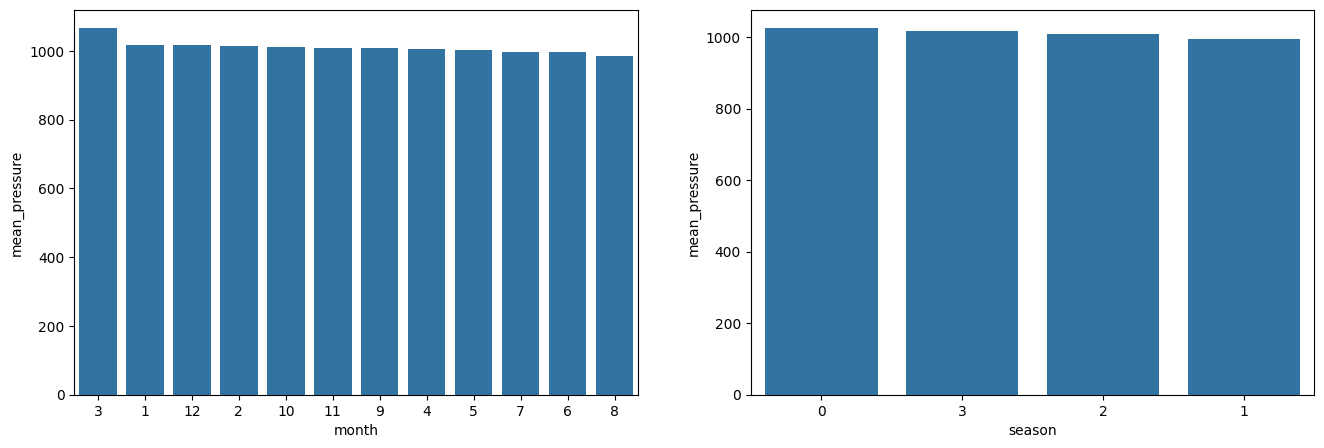

In [21]:
# mean_pressure over seasons and months
index = {'season', 'month'}
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
for i, ind in enumerate(index):
    index_sort = df_train.groupby(ind)['mean_pressure'].mean().sort_values(ascending=False).index
    sns.barplot(
        data = df_train,
        x = ind,
        y = 'mean_pressure',
        ax = ax[i],
        order = index_sort,
        errorbar = None,
        estimator=np.mean
    )

It is no surprise that the mean_pressure seem not to change over the year.

<a id="bivariate-analysis" ></a>
# Bivariate Analysis

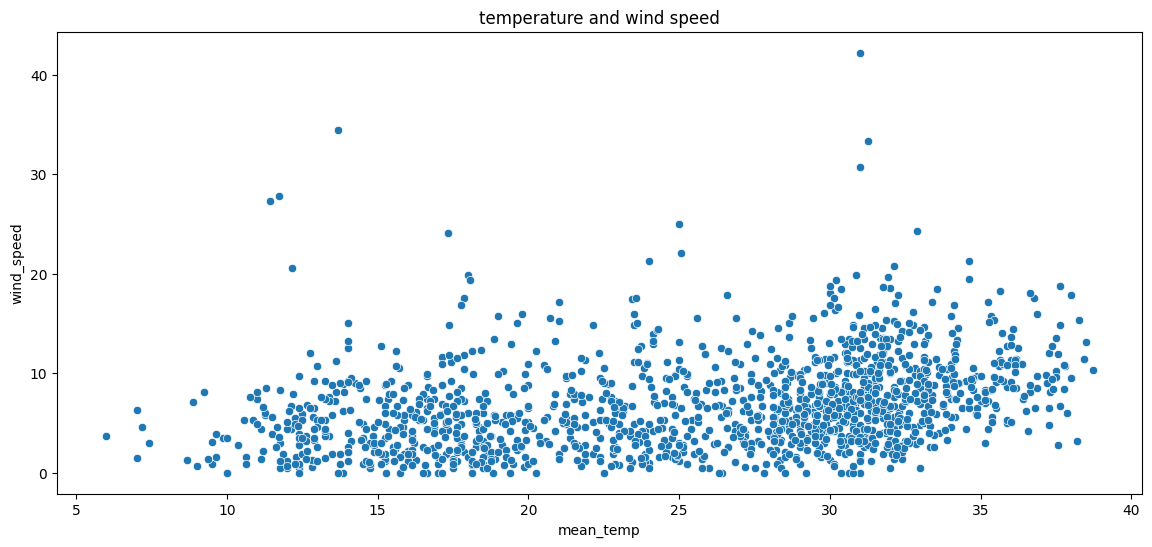

In [22]:
# mean_temp and wind_speed
plt.figure(figsize = (14,6))
sns.scatterplot(
    data = df_train,
    x = 'mean_temp',
    y = 'wind_speed',
)
plt.title('temperature and wind speed')
plt.show()

Wind sped tends to be low when the mean_temperature is low. 

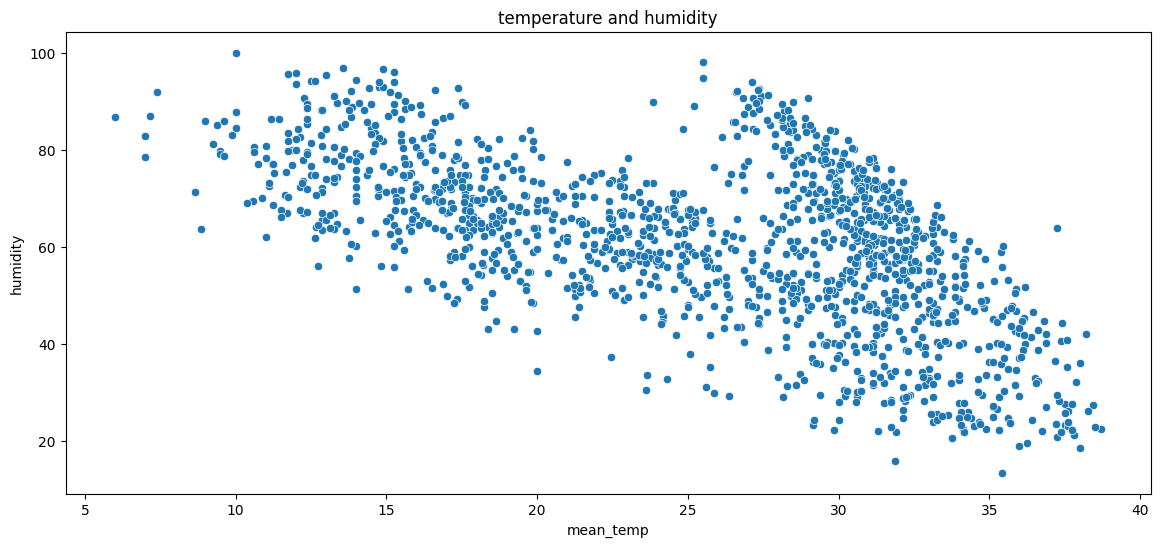

In [23]:
# mean_temp and humidity
plt.figure(figsize = (14,6))
sns.scatterplot(
    data = df_train,
    x = 'mean_temp',
    y = 'humidity',
)
plt.title('temperature and humidity')
plt.show()

We can see that the the humidity tends to be high when the temperature is low, and it tends to be low when the temperature is high.

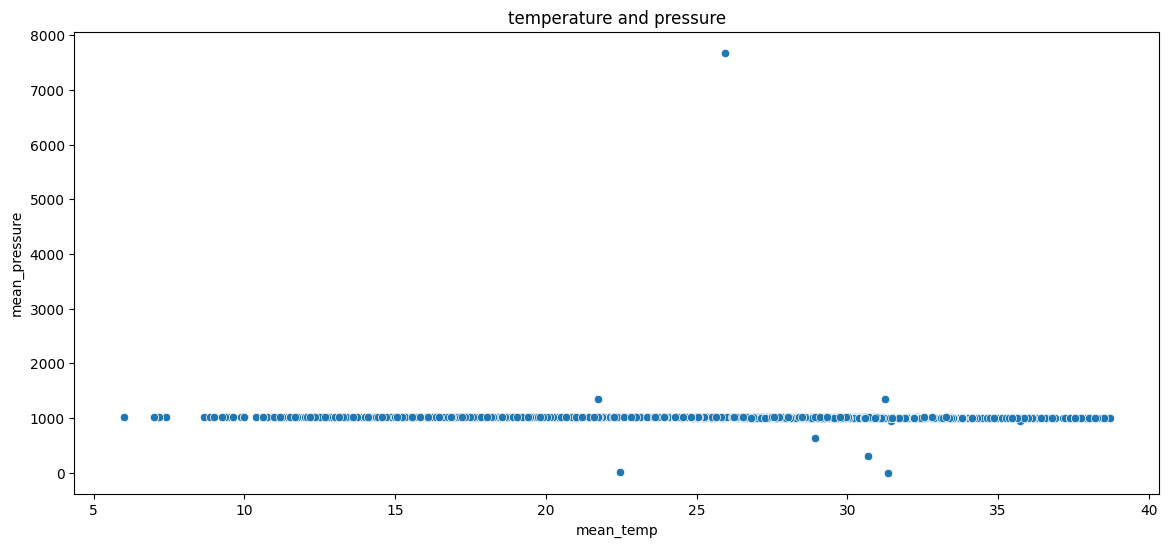

In [24]:
# mean_temp and pressure
plt.figure(figsize = (14,6))
sns.scatterplot(
    data = df_train,
    x = 'mean_temp',
    y = 'mean_pressure',
)
plt.title('temperature and pressure')
plt.show()

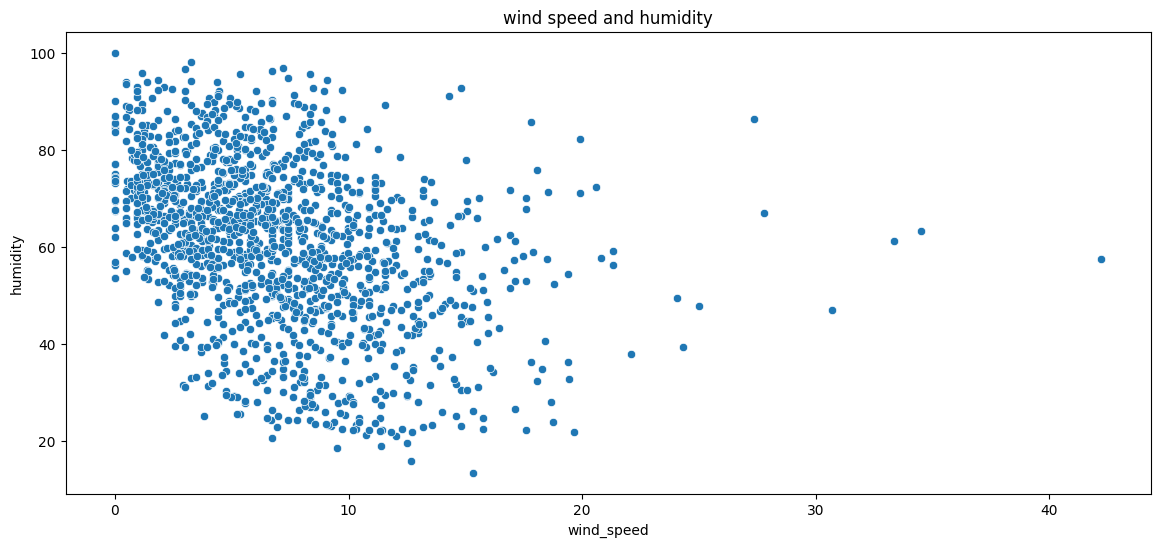

In [25]:
# wind_speed and humidity
plt.figure(figsize = (14,6))
sns.scatterplot(
    data = df_train,
    x = 'wind_speed',
    y = 'humidity',
)
plt.title('wind speed and humidity')
plt.show()

There may be higher humidity at lower wind speeds, which could be common in stable weather conditions without much wind.

<a id="a-first-look-at-time-series" ></a>
# A first look at time series

Because the values for mean_pressure is more or less constant, we can ignore this feature from now on.

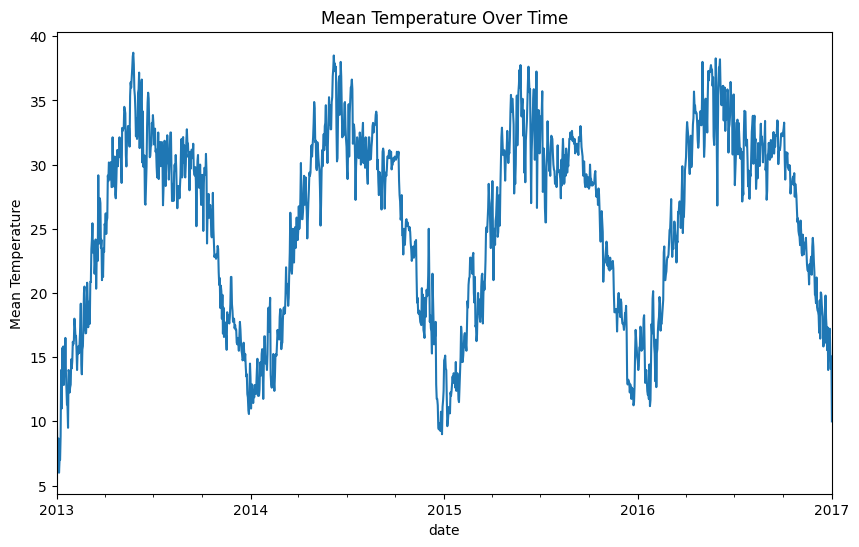

In [26]:
# Mean temperature over time
df_train.set_index('date', inplace=True)
df_train['mean_temp'].plot(figsize=(10, 6), title='Mean Temperature Over Time')
plt.xlabel('date')
plt.ylabel('Mean Temperature')
plt.show()

The mean_temp shows a clear seasonal pattern.

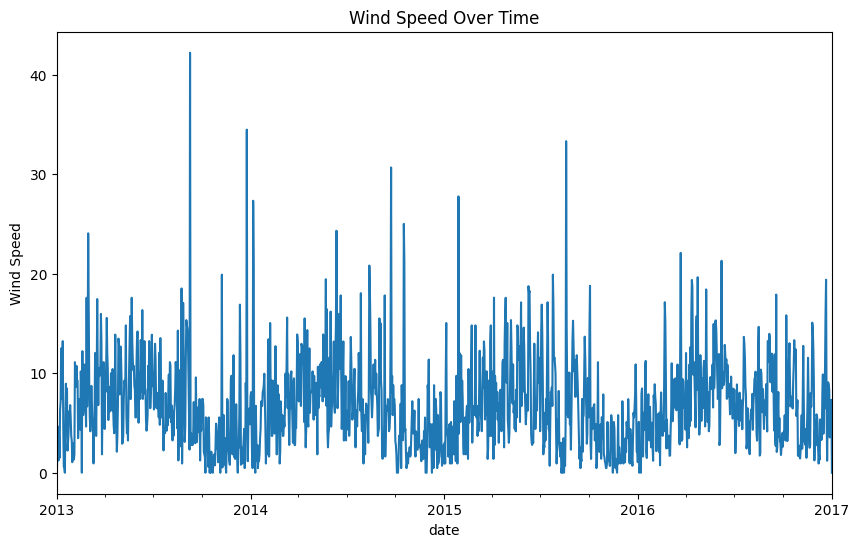

In [27]:
# Wind speed over time
df_train['wind_speed'].plot(figsize=(10, 6), title='Wind Speed Over Time')
plt.xlabel('date')
plt.ylabel('Wind Speed')
plt.show()

The seasonal pattern for wind speed is not very clear.

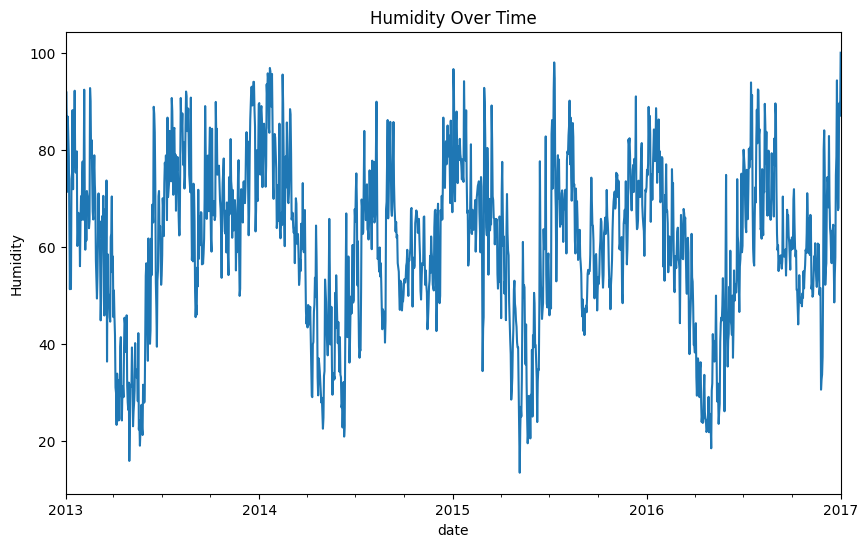

In [28]:
# humidity over time
df_train['humidity'].plot(figsize=(10, 6), title='Humidity Over Time')
plt.xlabel('date')
plt.ylabel('Humidity')
plt.show()

<a id="adf-test" ></a>
# ADF Test

In order to understand time series data, we need to see if the series are stationary. This condition is important to use ARIMA.

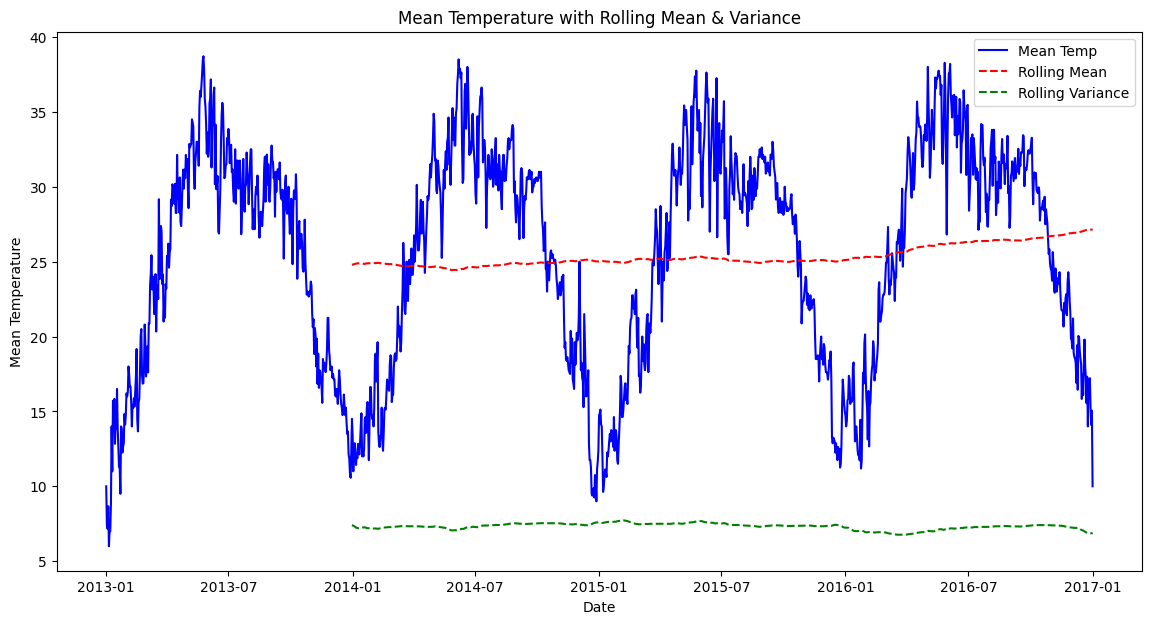

In [29]:
# Because it is daily data, we can choose the rolling windown = 365
rolling_mean = df_train['mean_temp'].rolling(window=365).mean()
rolling_var = df_train['mean_temp'].rolling(window=365).std()

# Plotting the time series along with the rolling statistics
plt.figure(figsize=(14, 7))
plt.plot(df_train['mean_temp'], label='Mean Temp', color='blue')
plt.plot(rolling_mean, label='Rolling Mean', color='red', linestyle='--')
plt.plot(rolling_var, label='Rolling Variance', color='green', linestyle='--')
plt.title('Mean Temperature with Rolling Mean & Variance')
plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.legend()
plt.show()

In [30]:
# ADF test
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_train['mean_temp'].values)
result

(-2.021069055920669,
 0.277412137230162,
 10,
 1451,
 {'1%': -3.4348647527922824,
  '5%': -2.863533960720434,
  '10%': -2.567831568508802},
 5423.895746470952)

The ADF test results show that mean_temp is not stationary. To make it stationary, we need to difference.

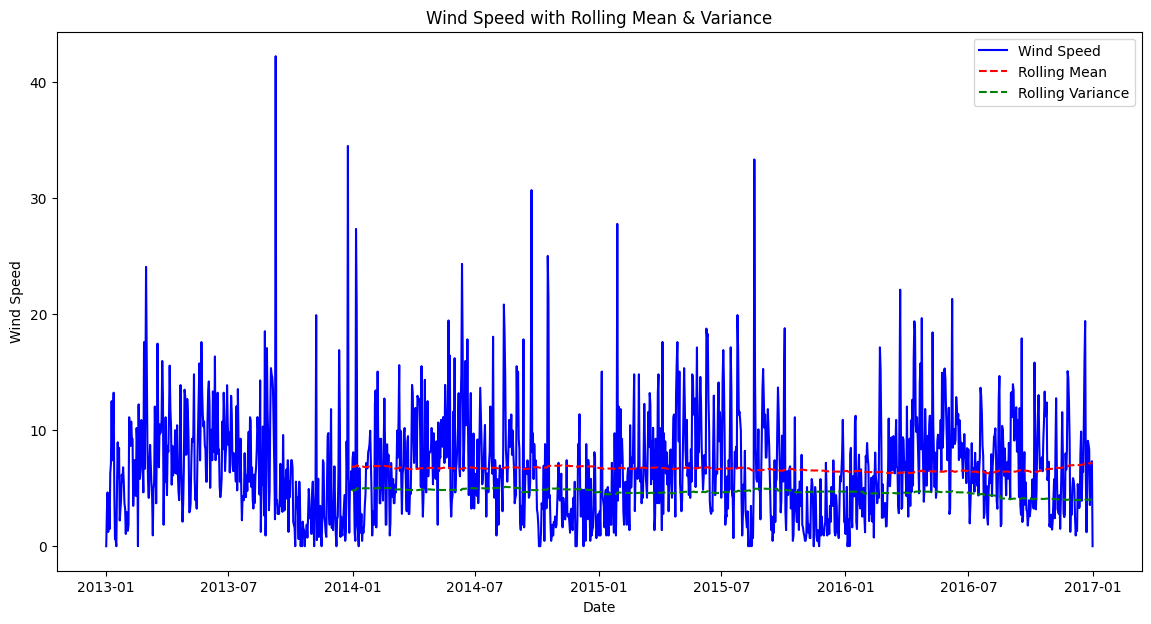

In [31]:
# Because it is daily data, we can choose the rolling windown = 365
rolling_mean = df_train['wind_speed'].rolling(window=365).mean()
rolling_var = df_train['wind_speed'].rolling(window=365).std()

# Plotting the time series along with the rolling statistics
plt.figure(figsize=(14, 7))
plt.plot(df_train['wind_speed'], label='Wind Speed', color='blue')
plt.plot(rolling_mean, label='Rolling Mean', color='red', linestyle='--')
plt.plot(rolling_var, label='Rolling Variance', color='green', linestyle='--')
plt.title('Wind Speed with Rolling Mean & Variance')
plt.xlabel('Date')
plt.ylabel('Wind Speed')
plt.legend()
plt.show()

In [32]:
# ADF test
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_train['wind_speed'].values)
result

(-3.8380967566850916,
 0.0025407221531465263,
 24,
 1437,
 {'1%': -3.434908816804013,
  '5%': -2.863553406963303,
  '10%': -2.5678419239852994},
 8107.698049704068)

The ADF test results show that the wind_speed is stationary (ADF statistics = -3.83 < critical value at 1% = -3.43 and p-value 0.0025 < 0.05).

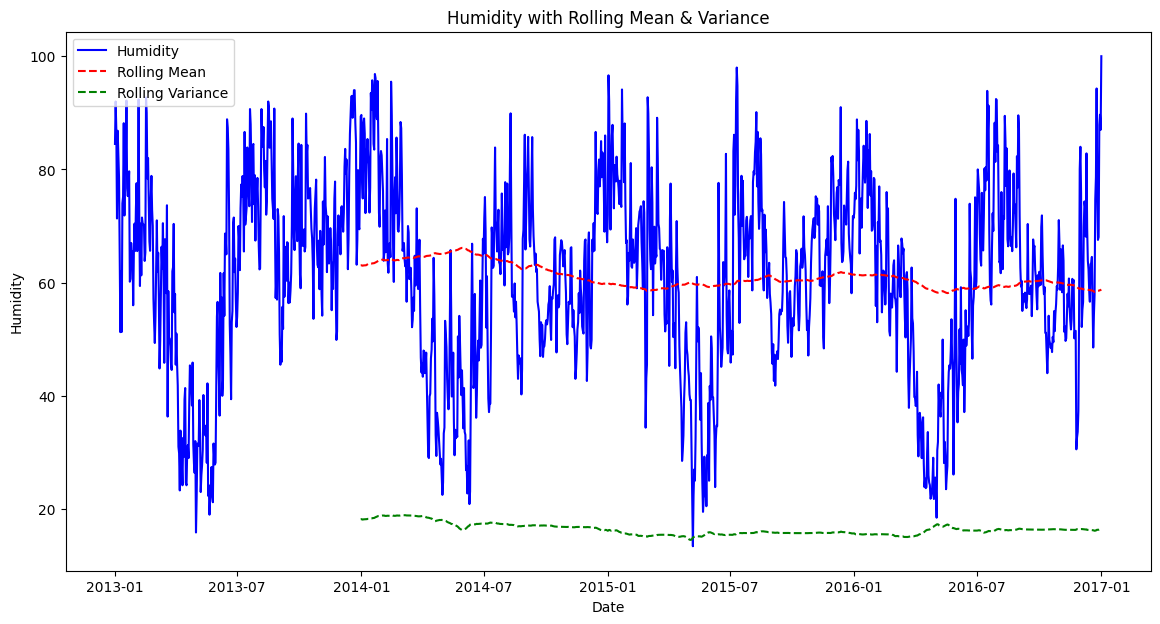

In [33]:
# Because it is daily data, we can choose the rolling windown = 365
rolling_mean = df_train['humidity'].rolling(window=365).mean()
rolling_var = df_train['humidity'].rolling(window=365).std()

# Plotting the time series along with the rolling statistics
plt.figure(figsize=(14, 7))
plt.plot(df_train['humidity'], label='Humidity', color='blue')
plt.plot(rolling_mean, label='Rolling Mean', color='red', linestyle='--')
plt.plot(rolling_var, label='Rolling Variance', color='green', linestyle='--')
plt.title('Humidity with Rolling Mean & Variance')
plt.xlabel('Date')
plt.ylabel('Humidity')
plt.legend()
plt.show()

In [34]:
# ADF test
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_train['humidity'].values)
result

(-3.6755769191633387,
 0.004470100478130771,
 15,
 1446,
 {'1%': -3.434880391815318,
  '5%': -2.8635408625359315,
  '10%': -2.5678352438452814},
 9961.530007876658)

The ADF test results show that humidity is stationary as well.

<a id="time-series-decomposition" ></a>
# Time series decomposition

In [35]:
from statsmodels.tsa.seasonal import seasonal_decompose

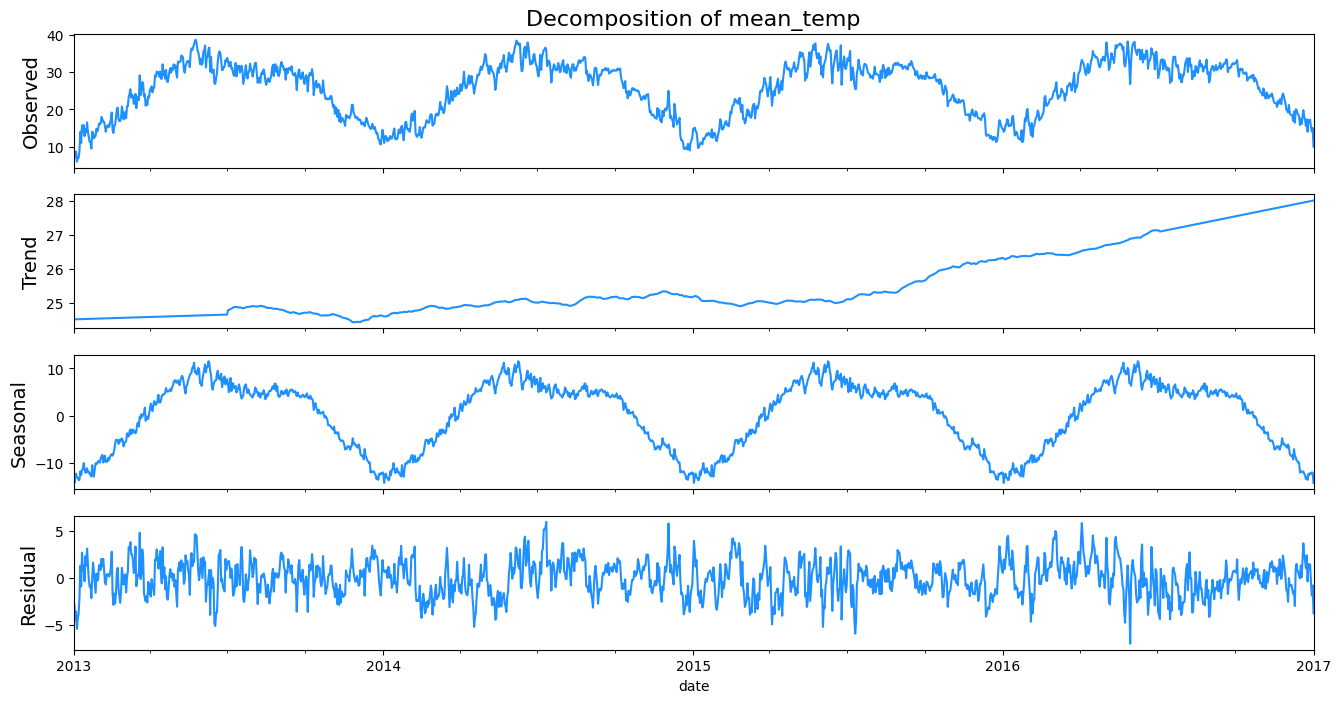

In [36]:
# Decomposition of mean_temp

fig, ax = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(16,8))
res = seasonal_decompose(df_train['mean_temp'], period = 365, model='additive', extrapolate_trend='freq')

ax[0].set_title('Decomposition of mean_temp', fontsize=16)
res.observed.plot(ax=ax[0], legend=False, color='dodgerblue')
ax[0].set_ylabel('Observed', fontsize=14)

res.trend.plot(ax=ax[1], legend=False, color='dodgerblue')
ax[1].set_ylabel('Trend', fontsize=14)

res.seasonal.plot(ax=ax[2], legend=False, color='dodgerblue')
ax[2].set_ylabel('Seasonal', fontsize=14)

res.resid.plot(ax=ax[3], legend=False, color='dodgerblue')
ax[3].set_ylabel('Residual', fontsize=14)

plt.show()

We can see that there is seasonal pattern for mean_temp, and the increasing trend is quite smooth.

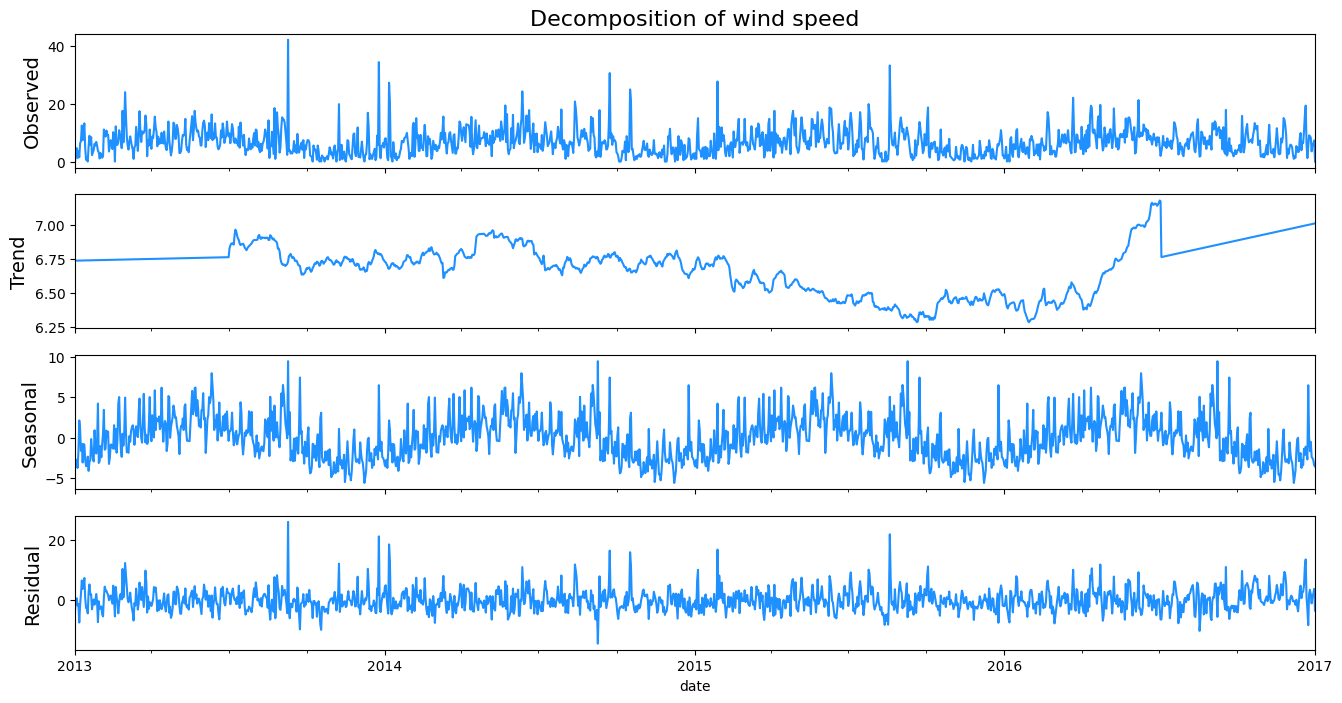

In [37]:
# Decomposition of wind_speed
fig, ax = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(16,8))
res = seasonal_decompose(df_train['wind_speed'], period = 365, model='additive', extrapolate_trend='freq')

ax[0].set_title('Decomposition of wind speed', fontsize=16)
res.observed.plot(ax=ax[0], legend=False, color='dodgerblue')
ax[0].set_ylabel('Observed', fontsize=14)

res.trend.plot(ax=ax[1], legend=False, color='dodgerblue')
ax[1].set_ylabel('Trend', fontsize=14)

res.seasonal.plot(ax=ax[2], legend=False, color='dodgerblue')
ax[2].set_ylabel('Seasonal', fontsize=14)

res.resid.plot(ax=ax[3], legend=False, color='dodgerblue')
ax[3].set_ylabel('Residual', fontsize=14)

plt.show()

We don't see a very clear seasonal pattern for wind_speed and the trend is also quite stable.

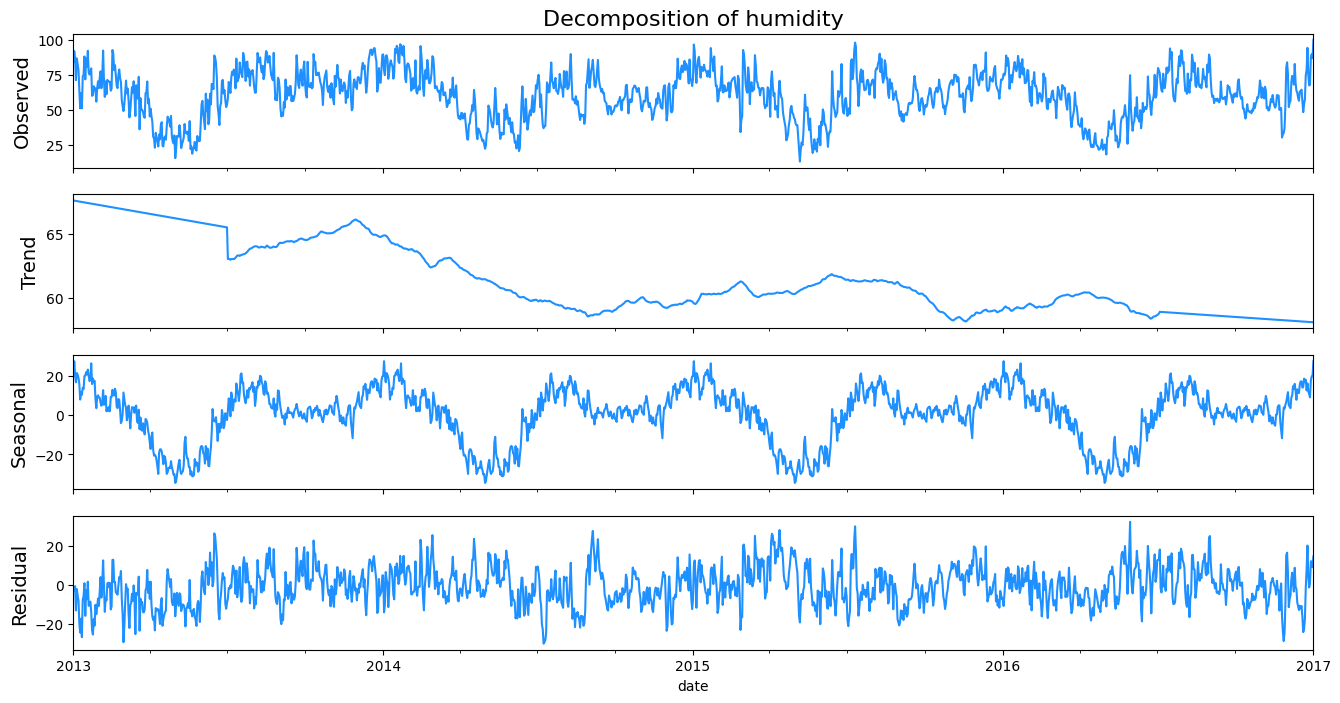

In [38]:
fig, ax = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(16,8))
res = seasonal_decompose(df_train['humidity'], period = 365, model='additive', extrapolate_trend='freq')

ax[0].set_title('Decomposition of humidity', fontsize=16)
res.observed.plot(ax=ax[0], legend=False, color='dodgerblue')
ax[0].set_ylabel('Observed', fontsize=14)

res.trend.plot(ax=ax[1], legend=False, color='dodgerblue')
ax[1].set_ylabel('Trend', fontsize=14)

res.seasonal.plot(ax=ax[2], legend=False, color='dodgerblue')
ax[2].set_ylabel('Seasonal', fontsize=14)

res.resid.plot(ax=ax[3], legend=False, color='dodgerblue')
ax[3].set_ylabel('Residual', fontsize=14)

plt.show()

For humidity, the seasonal pattern is not very clear, but it show there is seasonal, and we also have a decreasing trend.

<a id="auto-sarimax-model" ></a>
# Auto-SARIMAX Model 

***wind_speed and humidity are assumed to be known***

In [39]:
df_train

mean_temp    humidity  wind_speed  mean_pressure  day  week  \
date                                                                      
2013-01-01  10.000000   84.500000    0.000000    1015.666667    1     1   
2013-01-02   7.400000   92.000000    2.980000    1017.800000    2     1   
2013-01-03   7.166667   87.000000    4.633333    1018.666667    3     1   
2013-01-04   8.666667   71.333333    1.233333    1017.166667    4     1   
2013-01-05   6.000000   86.833333    3.700000    1016.500000    5     1   
...               ...         ...         ...            ...  ...   ...   
2016-12-28  17.217391   68.043478    3.547826    1015.565217   28    52   
2016-12-29  15.238095   87.857143    6.000000    1016.904762   29    52   
2016-12-30  14.095238   89.666667    6.266667    1017.904762   30    52   
2016-12-31  15.052632   87.000000    7.325000    1016.100000   31    52   
2017-01-01  10.000000  100.000000    0.000000    1016.000000    1    52   

            month  year  season  
date                             
2013-01-01      1  2013       3  
2013-01-02      1  2013       3  
2013-01-03      1  2013       3  
2013-01-04      1  2013       3  
2013-01-05      1  2013       3  
...           ...   ...     ...  
2016-12-28     12  2016       3  
2016-12-29     12  2016       3  
2016-12-30     12  2016       3  
2016-12-31     12  2016       3  
2017-01-01      1  2017       3  

[1462 rows x 9 columns]

In [41]:
import pmdarima as pm
from sklearn.metrics import mean_squared_error
from math import sqrt

In [42]:
train_size = int(len(df_train) * 0.8)
train, test = df_train.iloc[:train_size], df_train.iloc[train_size:]
print(train.shape)
print(test.shape)

(1169, 9)
(293, 9)


In [43]:
# Fitting the SARIMAX model on the training set
smodel = pm.auto_arima(train['mean_temp'], 
                    exogenous=train[['wind_speed', 'humidity']],
                    seasonal=True, 
                    m=12,   # The seasonal period, adjust if needed
                    d=None, # Let the model determine 'd'
                    D=None, # Let the model determine 'D'
                    stepwise=True,
                    trace = True,
                    error_action='ignore',  
                    suppress_warnings=True)

# Review the model summary
print(smodel.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=3.51 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=8007.623, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=4509.286, Time=1.77 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6222.706, Time=0.95 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=10905.678, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=4507.905, Time=0.18 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=4509.309, Time=0.87 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=2.12 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=4481.512, Time=0.12 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=4482.650, Time=2.42 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=4482.657, Time=0.89 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=2.90 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : AIC=4473.403, Time=0.17 sec
 ARIMA(3,0,0)(1,0,0)[12] intercept   : AIC=4474.736, Time=3.20 sec
 ARIMA(3,0,0)(0,0,1)[12] intercep

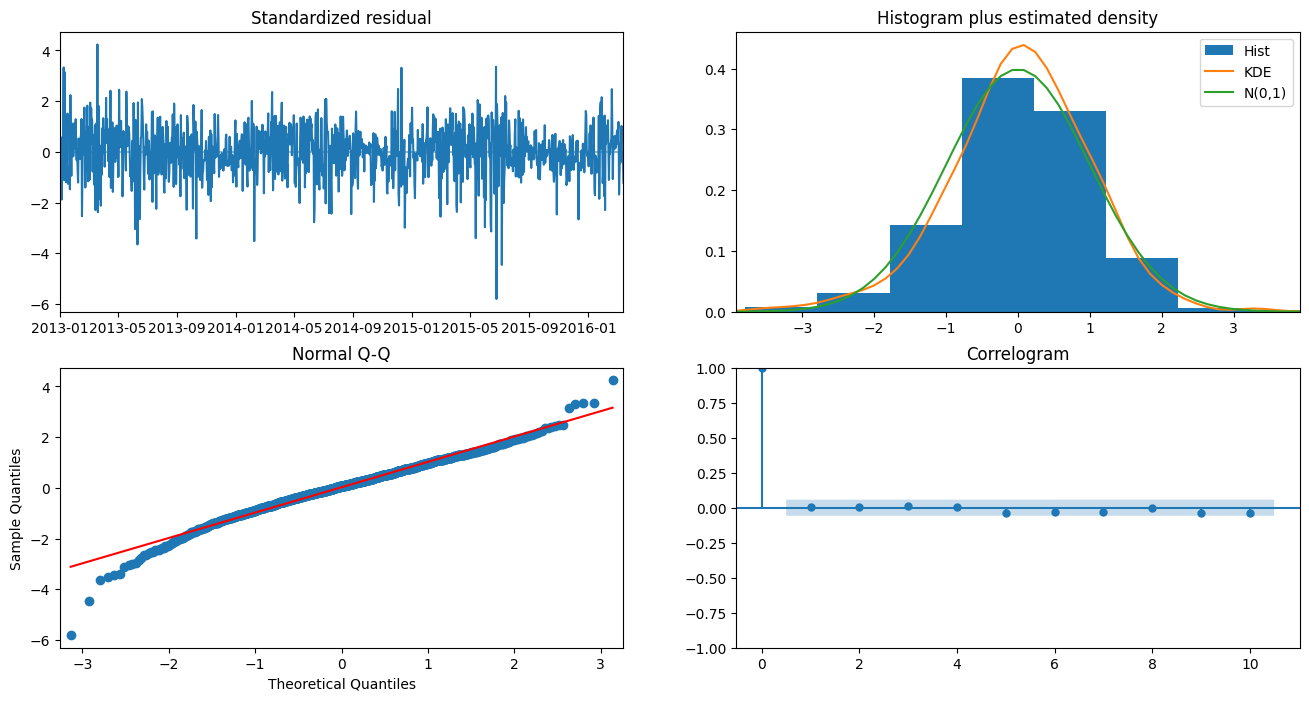

In [44]:
smodel.plot_diagnostics(figsize=(16,8))
plt.show()

In [45]:
train_pred, conf_int = smodel.predict(n_periods=train_size, 
                                      exogenous=train[['wind_speed', 'humidity']], 
                                      return_conf_int=True)
# Compute RMSE on the training set
train_rmse = np.sqrt(mean_squared_error(train['mean_temp'], train_pred))
print(f"Train RMSE: {train_rmse}")

# Forecast on the test set
test_pred, conf_int = smodel.predict(n_periods=len(test), 
                                     exogenous=test[['wind_speed', 'humidity']], 
                                     return_conf_int=True)

# Compute RMSE on the test set
test_rmse = np.sqrt(mean_squared_error(test['mean_temp'], test_pred))
print(f"Test RMSE: {test_rmse}")

Train RMSE: 7.634770100825714
Test RMSE: 8.337265331873576


<a id="univariate-prophet" ></a>
# Univariate Prophet

In [46]:
df_train_reset = df_train.reset_index()
df_train_reset

date  mean_temp    humidity  wind_speed  mean_pressure  day  week  \
0    2013-01-01  10.000000   84.500000    0.000000    1015.666667    1     1   
1    2013-01-02   7.400000   92.000000    2.980000    1017.800000    2     1   
2    2013-01-03   7.166667   87.000000    4.633333    1018.666667    3     1   
3    2013-01-04   8.666667   71.333333    1.233333    1017.166667    4     1   
4    2013-01-05   6.000000   86.833333    3.700000    1016.500000    5     1   
...         ...        ...         ...         ...            ...  ...   ...   
1457 2016-12-28  17.217391   68.043478    3.547826    1015.565217   28    52   
1458 2016-12-29  15.238095   87.857143    6.000000    1016.904762   29    52   
1459 2016-12-30  14.095238   89.666667    6.266667    1017.904762   30    52   
1460 2016-12-31  15.052632   87.000000    7.325000    1016.100000   31    52   
1461 2017-01-01  10.000000  100.000000    0.000000    1016.000000    1    52   

      month  year  season  
0         1  2013       3  
1         1  2013       3  
2         1  2013       3  
3         1  2013       3  
4         1  2013       3  
...     ...   ...     ...  
1457     12  2016       3  
1458     12  2016       3  
1459     12  2016       3  
1460     12  2016       3  
1461      1  2017       3  

[1462 rows x 10 columns]

In [47]:
df_train_reset = df_train_reset.rename(columns={'date': 'ds', 'mean_temp': 'y'})
# Rename 'Date' column to 'ds' to fit Prophet's expected column name
df_train_reset = df_train_reset.rename(columns={'Date': 'ds'})
df_train_reset

ds          y    humidity  wind_speed  mean_pressure  day  week  \
0    2013-01-01  10.000000   84.500000    0.000000    1015.666667    1     1   
1    2013-01-02   7.400000   92.000000    2.980000    1017.800000    2     1   
2    2013-01-03   7.166667   87.000000    4.633333    1018.666667    3     1   
3    2013-01-04   8.666667   71.333333    1.233333    1017.166667    4     1   
4    2013-01-05   6.000000   86.833333    3.700000    1016.500000    5     1   
...         ...        ...         ...         ...            ...  ...   ...   
1457 2016-12-28  17.217391   68.043478    3.547826    1015.565217   28    52   
1458 2016-12-29  15.238095   87.857143    6.000000    1016.904762   29    52   
1459 2016-12-30  14.095238   89.666667    6.266667    1017.904762   30    52   
1460 2016-12-31  15.052632   87.000000    7.325000    1016.100000   31    52   
1461 2017-01-01  10.000000  100.000000    0.000000    1016.000000    1    52   

      month  year  season  
0         1  2013       3  
1         1  2013       3  
2         1  2013       3  
3         1  2013       3  
4         1  2013       3  
...     ...   ...     ...  
1457     12  2016       3  
1458     12  2016       3  
1459     12  2016       3  
1460     12  2016       3  
1461      1  2017       3  

[1462 rows x 10 columns]

In [48]:
from prophet import Prophet

/Users/khanhdam/.local/share/virtualenvs/TimeSeries_StackingModels-SOMotZfp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [49]:
from sklearn.model_selection import train_test_split
# Split the reset dataset
p_train, p_test = train_test_split(df_train_reset, test_size=0.2, shuffle=False)

# Initialize the Prophet model
model = Prophet()

# Fit the model with the DataFrame
model.fit(p_train)

16:20:52 - cmdstanpy - INFO - Chain [1] start processing
16:20:53 - cmdstanpy - INFO - Chain [1] done processing


In [50]:
future = model.make_future_dataframe(periods=len(p_test))

In [51]:
future

ds
0    2013-01-01
1    2013-01-02
2    2013-01-03
3    2013-01-04
4    2013-01-05
...         ...
1457 2016-12-28
1458 2016-12-29
1459 2016-12-30
1460 2016-12-31
1461 2017-01-01

[1462 rows x 1 columns]

In [52]:
# Predict future values
forecast = model.predict(future)

In [53]:
# RMSE on training set
y_train_pred = forecast['yhat'][:len(p_train)].values
y_train_true = p_train['y'].values
rmse = np.sqrt(mean_squared_error(y_train_true, y_train_pred))

print(f'RMSE: {rmse}')

RMSE: 2.0160546797959378


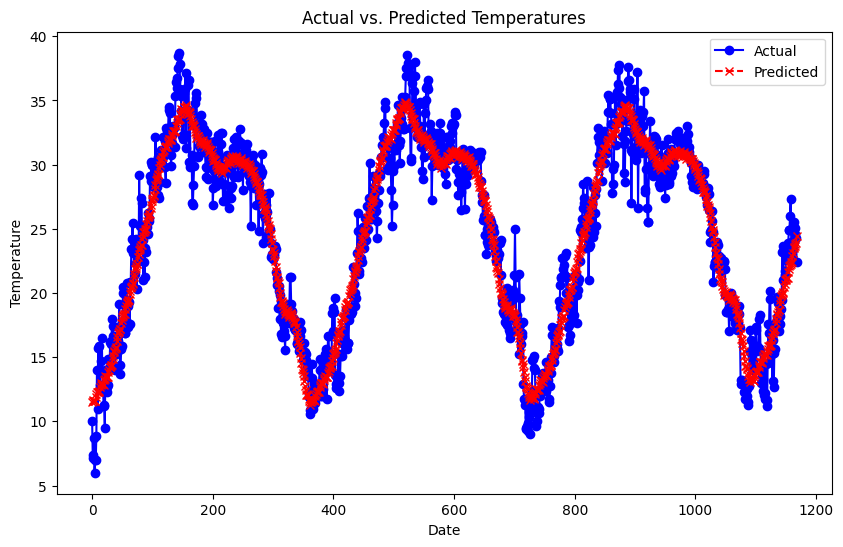

In [54]:
# Plot on p_train
plt.figure(figsize=(10, 6))
plt.plot(y_train_true, label='Actual', color='blue', marker='o')
plt.plot(y_train_pred, label='Predicted', color='red', linestyle='--', marker='x')
plt.title('Actual vs. Predicted Temperatures')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [55]:
# Extract the predicted and actual values
y_pred = forecast['yhat'][-len(p_test):]  # Last 'len(p_test)' predictions
y_true = p_test['y'].values

rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f'RMSE: {rmse}')

RMSE: 2.768550691521725


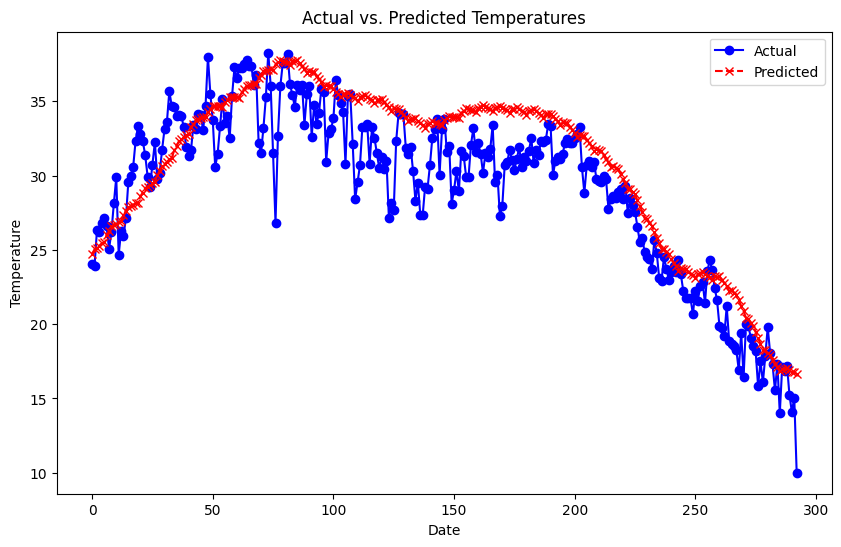

In [56]:
y_pred = y_pred.values
plt.figure(figsize=(10, 6))
plt.plot(y_true, label='Actual', color='blue', marker='o')
plt.plot(y_pred, label='Predicted', color='red', linestyle='--', marker='x')
plt.title('Actual vs. Predicted Temperatures')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

<a id="multivariate-prophet" ></a>
# Multivariate Prophet 

***Assume wind_speed and humidity are known***

In [57]:
model = Prophet()
model.add_regressor('wind_speed')
model.add_regressor('humidity')

In [58]:
model.fit(p_train)

16:20:54 - cmdstanpy - INFO - Chain [1] start processing
16:20:54 - cmdstanpy - INFO - Chain [1] done processing


In [59]:
future = model.make_future_dataframe(periods=len(p_test))

In [60]:
future

ds
0    2013-01-01
1    2013-01-02
2    2013-01-03
3    2013-01-04
4    2013-01-05
...         ...
1457 2016-12-28
1458 2016-12-29
1459 2016-12-30
1460 2016-12-31
1461 2017-01-01

[1462 rows x 1 columns]

In [61]:
future['wind_speed'] = df_train_reset['wind_speed']
future['humidity'] = df_train_reset['humidity']

In [62]:
future

ds  wind_speed    humidity
0    2013-01-01    0.000000   84.500000
1    2013-01-02    2.980000   92.000000
2    2013-01-03    4.633333   87.000000
3    2013-01-04    1.233333   71.333333
4    2013-01-05    3.700000   86.833333
...         ...         ...         ...
1457 2016-12-28    3.547826   68.043478
1458 2016-12-29    6.000000   87.857143
1459 2016-12-30    6.266667   89.666667
1460 2016-12-31    7.325000   87.000000
1461 2017-01-01    0.000000  100.000000

[1462 rows x 3 columns]

In [63]:
# Predict future values
forecast = model.predict(future)

In [64]:
# Extract the predicted and actual values
y_pred = forecast['yhat'][-len(p_test):]  # Last 'len(p_test)' predictions
y_true = p_test['y'].values

rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f'RMSE: {rmse}')

RMSE: 1.6584104210571027


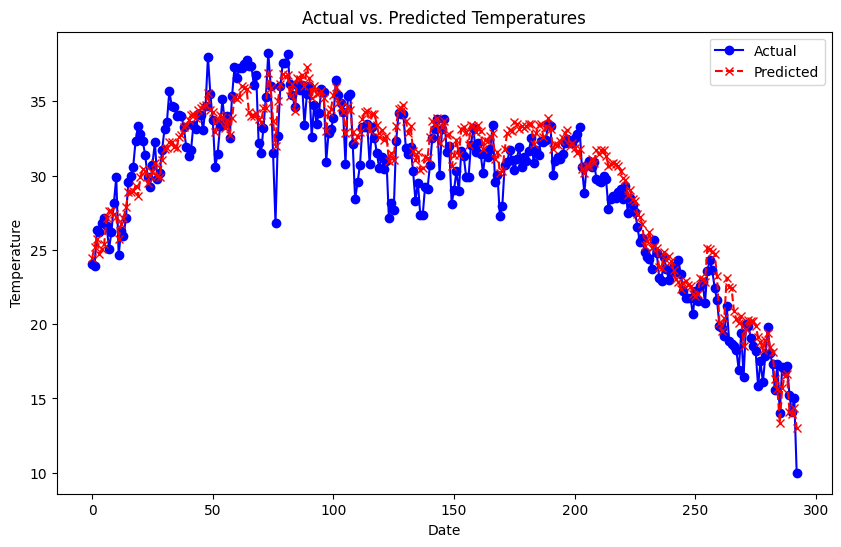

In [65]:
y_pred = y_pred.values
plt.figure(figsize=(10, 6))
plt.plot(y_true, label='Actual', color='blue', marker='o')
plt.plot(y_pred, label='Predicted', color='red', linestyle='--', marker='x')
plt.title('Actual vs. Predicted Temperatures')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

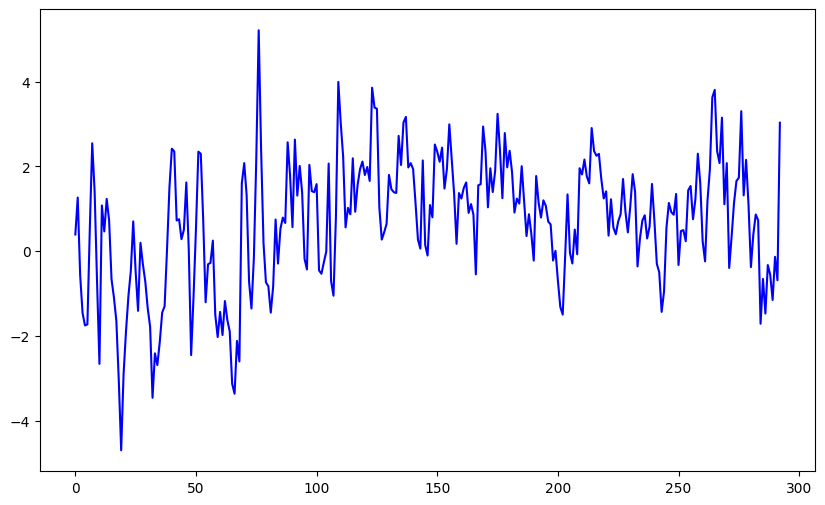

In [66]:
residuals = y_pred - y_true
plt.figure(figsize=(10, 6))
plt.plot(residuals, label='Residuals', color='blue')
plt.show()

<Axes: ylabel='Count'>

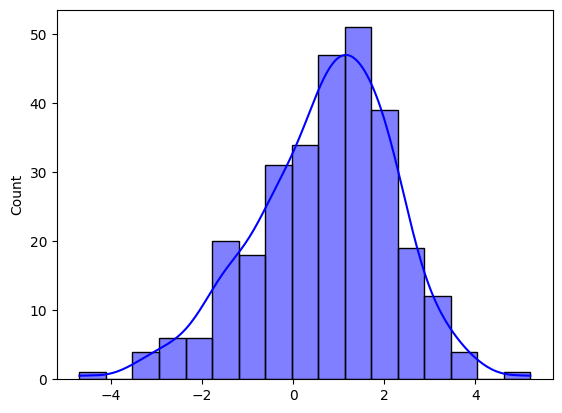

In [67]:
# Histogrm of residuals
sns.histplot(
    data = residuals,
    kde = True,
    color = 'blue'
)

The residual is a little bit left-skewed, because the increasing of mean temperature from the later half of 2015 and because this belong to test set, we do not capture well this information. Let's add change point to prophet and check the results again.

<a id="changepoints-added" ></a>
# Changepoints added

In [68]:
model = Prophet(changepoints=['2015-05-01'])

In [69]:
model.add_regressor('wind_speed')
model.add_regressor('humidity')

In [70]:
model.fit(p_train)

16:20:55 - cmdstanpy - INFO - Chain [1] start processing
16:20:55 - cmdstanpy - INFO - Chain [1] done processing


In [71]:
future = model.make_future_dataframe(periods=len(p_test))

In [72]:
future

ds
0    2013-01-01
1    2013-01-02
2    2013-01-03
3    2013-01-04
4    2013-01-05
...         ...
1457 2016-12-28
1458 2016-12-29
1459 2016-12-30
1460 2016-12-31
1461 2017-01-01

[1462 rows x 1 columns]

In [73]:
future['wind_speed'] = df_train_reset['wind_speed']
future['humidity'] = df_train_reset['humidity']

In [74]:
future

ds  wind_speed    humidity
0    2013-01-01    0.000000   84.500000
1    2013-01-02    2.980000   92.000000
2    2013-01-03    4.633333   87.000000
3    2013-01-04    1.233333   71.333333
4    2013-01-05    3.700000   86.833333
...         ...         ...         ...
1457 2016-12-28    3.547826   68.043478
1458 2016-12-29    6.000000   87.857143
1459 2016-12-30    6.266667   89.666667
1460 2016-12-31    7.325000   87.000000
1461 2017-01-01    0.000000  100.000000

[1462 rows x 3 columns]

In [75]:
# Predict future values
forecast = model.predict(future)

In [76]:
# Extract the predicted and actual values
y_pred = forecast['yhat'][-len(p_test):]  # Last 'len(p_test)' predictions
y_true = p_test['y'].values

rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f'RMSE: {rmse}')

RMSE: 1.4806915122022013


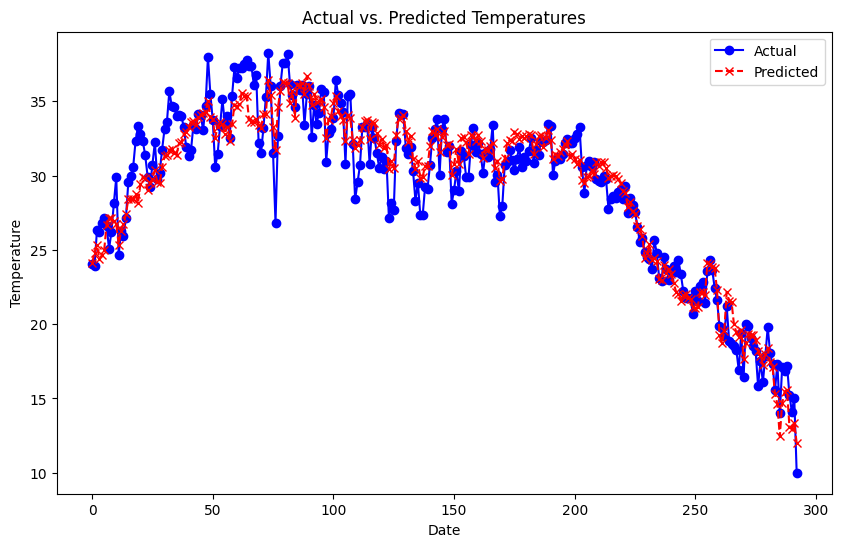

In [77]:
y_pred = y_pred.values
plt.figure(figsize=(10, 6))
plt.plot(y_true, label='Actual', color='blue', marker='o')
plt.plot(y_pred, label='Predicted', color='red', linestyle='--', marker='x')
plt.title('Actual vs. Predicted Temperatures')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

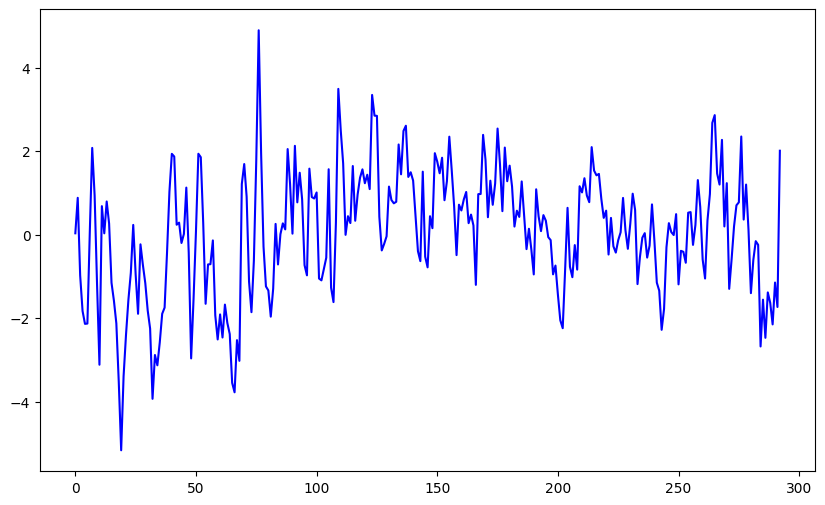

In [78]:
residuals = y_pred - y_true
plt.figure(figsize=(10, 6))
plt.plot(residuals, label='Residuals', color='blue')
plt.show()

<Axes: ylabel='Count'>

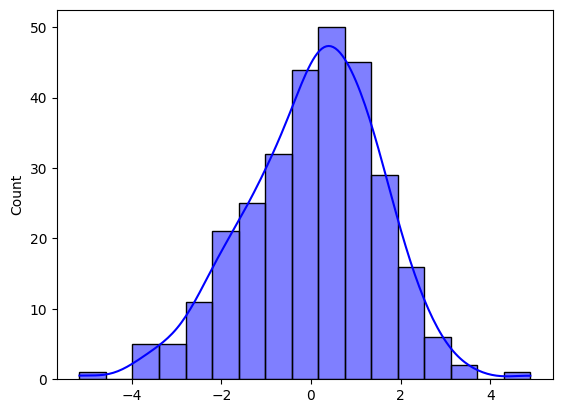

In [79]:
# Histogrm of residuals
sns.histplot(
    data = residuals,
    kde = True,
    color = 'blue'
)

The histogram looks more symmetric with change point. We will now fit the whole data and test it on df_test. 

There are two approaches: 

- Univariate approach: we will only use the history values of mean temperature to predict it on the test set.

- Multivariate approach: for this, we would need to predict values of wind_speed and humidity first and fit it to the multivariate prophet.

<a id="univariate-prophet-revisited" ></a>
# Univariate Prophet revisited

In [80]:
df_test

date   meantemp   humidity  wind_speed  meanpressure
0    2017-01-01  15.913043  85.869565    2.743478     59.000000
1    2017-01-02  18.500000  77.222222    2.894444   1018.277778
2    2017-01-03  17.111111  81.888889    4.016667   1018.333333
3    2017-01-04  18.700000  70.050000    4.545000   1015.700000
4    2017-01-05  18.388889  74.944444    3.300000   1014.333333
..          ...        ...        ...         ...           ...
109  2017-04-20  34.500000  27.500000    5.562500    998.625000
110  2017-04-21  34.250000  39.375000    6.962500    999.875000
111  2017-04-22  32.900000  40.900000    8.890000   1001.600000
112  2017-04-23  32.875000  27.500000    9.962500   1002.125000
113  2017-04-24  32.000000  27.142857   12.157143   1004.142857

[114 rows x 5 columns]

In [81]:
df_test['date'] = pd.to_datetime(df_test['date'], format = '%Y-%m-%d')

In [82]:
df_test = df_test.rename(columns = {'meantemp': 'mean_temp', 'meanpressure': 'mean_pressure'})

In [83]:
df_test

date  mean_temp   humidity  wind_speed  mean_pressure
0   2017-01-01  15.913043  85.869565    2.743478      59.000000
1   2017-01-02  18.500000  77.222222    2.894444    1018.277778
2   2017-01-03  17.111111  81.888889    4.016667    1018.333333
3   2017-01-04  18.700000  70.050000    4.545000    1015.700000
4   2017-01-05  18.388889  74.944444    3.300000    1014.333333
..         ...        ...        ...         ...            ...
109 2017-04-20  34.500000  27.500000    5.562500     998.625000
110 2017-04-21  34.250000  39.375000    6.962500     999.875000
111 2017-04-22  32.900000  40.900000    8.890000    1001.600000
112 2017-04-23  32.875000  27.500000    9.962500    1002.125000
113 2017-04-24  32.000000  27.142857   12.157143    1004.142857

[114 rows x 5 columns]

In [84]:
p_model = Prophet()

In [85]:
p_model.fit(df_train_reset)

16:20:56 - cmdstanpy - INFO - Chain [1] start processing
16:20:56 - cmdstanpy - INFO - Chain [1] done processing


In [86]:
future = p_model.make_future_dataframe(periods=len(df_test))

In [87]:
forecast = p_model.predict(future)

In [88]:
# RMSE on df_train
y_train_pred = forecast['yhat'][:len(df_train_reset):].values  # Last 'len(p_test)' predictions
y_train_true = df_train_reset['y'].values

rmse = np.sqrt(mean_squared_error(y_train_true, y_train_pred))

print(f'RMSE: {rmse}')

RMSE: 2.0315403176136138


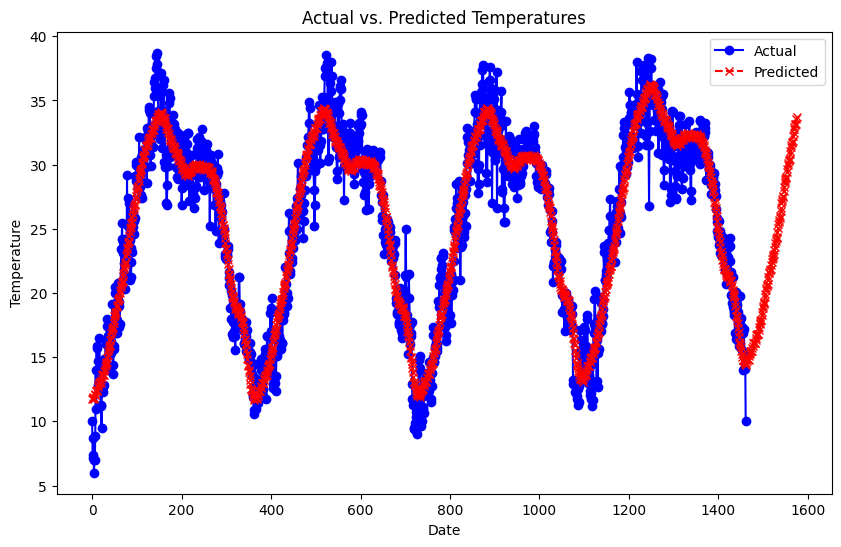

In [89]:
# Plot on df_train
plt.figure(figsize=(10, 6))
plt.plot(y_train_true, label='Actual', color='blue', marker='o')
plt.plot(forecast['yhat'].values, label='Predicted', color='red', linestyle='--', marker='x')
plt.title('Actual vs. Predicted Temperatures')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

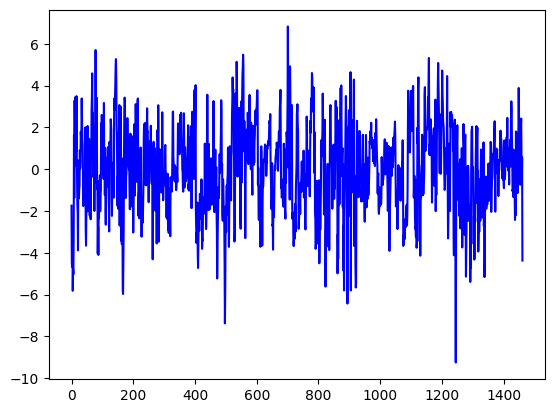

In [90]:
# Residuals plot on df_train
residuals = y_train_true - y_train_pred
plt.plot(
    residuals,
    color = 'blue'
)

<Axes: ylabel='Count'>

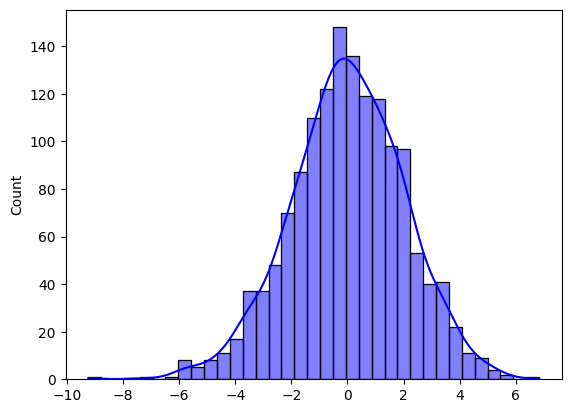

In [91]:
# Histplot on df_train
import seaborn as sns
sns.histplot(
    data=residuals,
    kde=True,
    color = 'blue'
)

It seems to have a little bit left tail, but it looks quite good.

In [92]:
# RMSE for df_test
y_pred = forecast['yhat'][-len(df_test):]  # Last 'len(p_test)' predictions
y_true = df_test['mean_temp'].values

rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f'RMSE: {rmse}')

RMSE: 2.7537540661806013


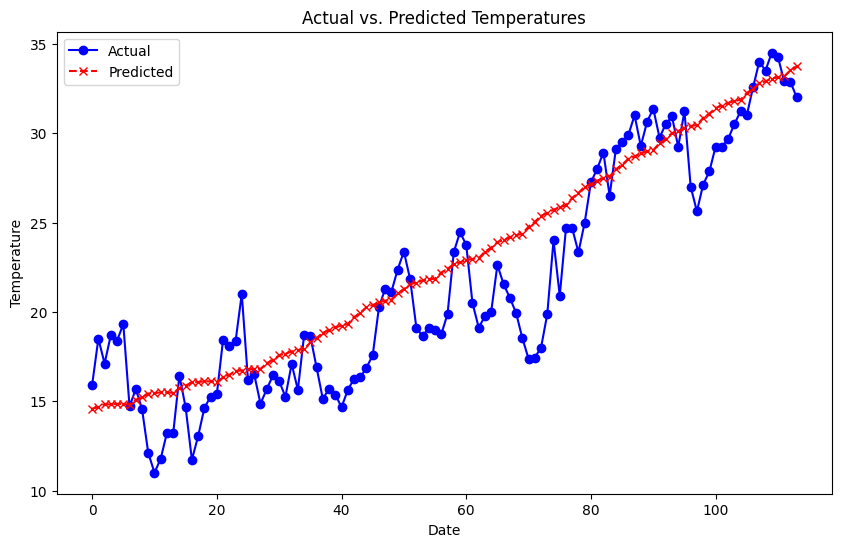

In [93]:
# Plot for df_test
plt.figure(figsize=(10, 6))
plt.plot(y_true, label='Actual', color='blue', marker='o')
plt.plot(y_pred.values, label='Predicted', color='red', linestyle='--', marker='x')
plt.title('Actual vs. Predicted Temperatures')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

<Axes: ylabel='Count'>

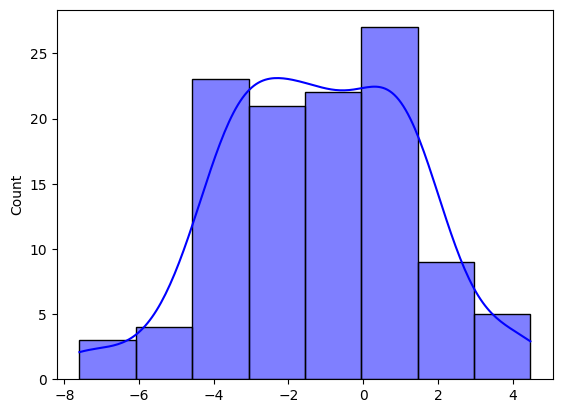

In [94]:
# Residuals distribution
residuals = y_true - y_pred.values
sns.histplot(
    data=residuals,
    kde=True,
    color='blue'
)

- The histogram appears to be slightly skewed to the left, which suggests that there is a tendency for the Prophet model to overestimate the values.
- The distribution of residuals is not centered around zero, indicating a bias in the forecasts.
- The tails, especially the left tail, seem to be heavier, indicating the presence of some larger errors.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


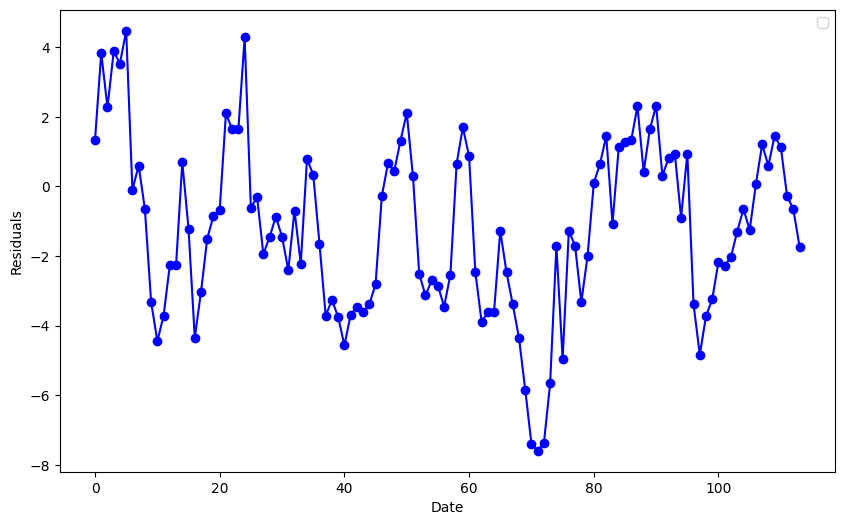

In [95]:
# Residuals plot
plt.figure(figsize=(10, 6))
plt.plot(residuals, color='blue', marker='o')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()

From the residuals distribution and plot, we can see that the residuals is not centered around 0 and also not symmetric around the center. It could be because prophet did not capture well trends. 

/Users/khanhdam/.local/share/virtualenvs/TimeSeries_StackingModels-SOMotZfp/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/khanhdam/.local/share/virtualenvs/TimeSeries_StackingModels-SOMotZfp/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


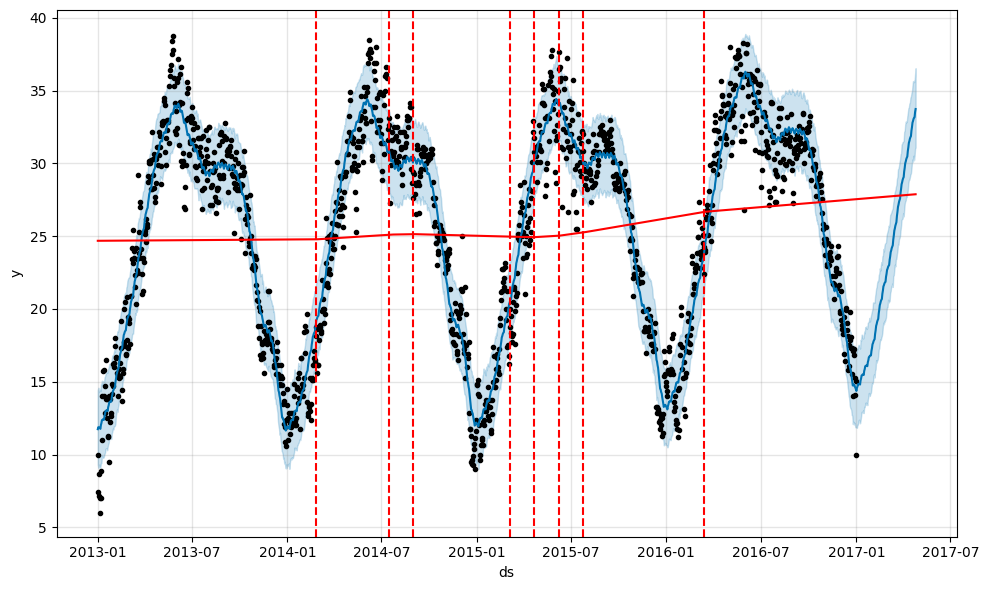

In [96]:
from prophet.plot import add_changepoints_to_plot
fig = p_model.plot(forecast)
# Add change points to the plot
a = add_changepoints_to_plot(fig.gca(), p_model, forecast)

You can change it by manually adding change point or set higher changepoint_prior_scale (default = 0.05).

<a id="improvements" ></a>
# Improvements.

<a id="ensembling-method" ></a>
# Ensembling method

We will use XG Boost on the residuals to see if the result is improved. It is good to have more features for XG Boost, and we can add cyclical features, for example: day of year, week, month and season.

In [97]:
columns = ['ds', 'day', 'week', 'month', 'year', 'season']
df_xg = df_train_reset[columns]
df_xg

ds  day  week  month  year  season
0    2013-01-01    1     1      1  2013       3
1    2013-01-02    2     1      1  2013       3
2    2013-01-03    3     1      1  2013       3
3    2013-01-04    4     1      1  2013       3
4    2013-01-05    5     1      1  2013       3
...         ...  ...   ...    ...   ...     ...
1457 2016-12-28   28    52     12  2016       3
1458 2016-12-29   29    52     12  2016       3
1459 2016-12-30   30    52     12  2016       3
1460 2016-12-31   31    52     12  2016       3
1461 2017-01-01    1    52      1  2017       3

[1462 rows x 6 columns]

In [98]:
df_xg['residuals'] = y_train_true - y_train_pred
df_xg

/var/folders/rt/q1nqm7vd4j175p7gyf5tqnhh0000gn/T/ipykernel_9387/1708336339.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xg['residuals'] = y_train_true - y_train_pred


ds  day  week  month  year  season  residuals
0    2013-01-01    1     1      1  2013       3  -1.741082
1    2013-01-02    2     1      1  2013       3  -4.477047
2    2013-01-03    3     1      1  2013       3  -4.670250
3    2013-01-04    4     1      1  2013       3  -3.182896
4    2013-01-05    5     1      1  2013       3  -5.816476
...         ...  ...   ...    ...   ...     ...        ...
1457 2016-12-28   28    52     12  2016       3   2.425625
1458 2016-12-29   29    52     12  2016       3   0.576659
1459 2016-12-30   30    52     12  2016       3  -0.496896
1460 2016-12-31   31    52     12  2016       3   0.566548
1461 2017-01-01    1    52      1  2017       3  -4.369535

[1462 rows x 7 columns]

In [99]:
df_xg['day_of_year'] = df_xg['ds'].dt.dayofyear
df_xg

/var/folders/rt/q1nqm7vd4j175p7gyf5tqnhh0000gn/T/ipykernel_9387/1028300098.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xg['day_of_year'] = df_xg['ds'].dt.dayofyear


ds  day  week  month  year  season  residuals  day_of_year
0    2013-01-01    1     1      1  2013       3  -1.741082            1
1    2013-01-02    2     1      1  2013       3  -4.477047            2
2    2013-01-03    3     1      1  2013       3  -4.670250            3
3    2013-01-04    4     1      1  2013       3  -3.182896            4
4    2013-01-05    5     1      1  2013       3  -5.816476            5
...         ...  ...   ...    ...   ...     ...        ...          ...
1457 2016-12-28   28    52     12  2016       3   2.425625          363
1458 2016-12-29   29    52     12  2016       3   0.576659          364
1459 2016-12-30   30    52     12  2016       3  -0.496896          365
1460 2016-12-31   31    52     12  2016       3   0.566548          366
1461 2017-01-01    1    52      1  2017       3  -4.369535            1

[1462 rows x 8 columns]

/var/folders/rt/q1nqm7vd4j175p7gyf5tqnhh0000gn/T/ipykernel_9387/3115375824.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xg['day_sin'] = np.sin(2*np.pi*df_xg['day_of_year']/365)


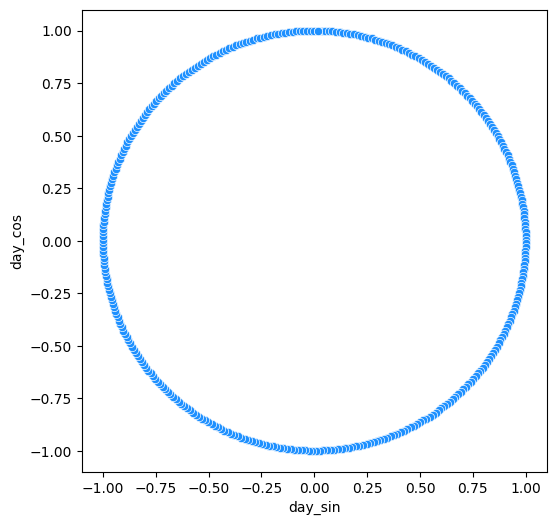

In [100]:
df_xg['day_sin'] = np.sin(2*np.pi*df_xg['day_of_year']/365)
df_xg['day_cos'] = np.cos(2*np.pi*df_xg['day_of_year']/365)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.scatterplot(x=df_xg.day_sin, y=df_xg.day_cos, color='dodgerblue')
plt.show()

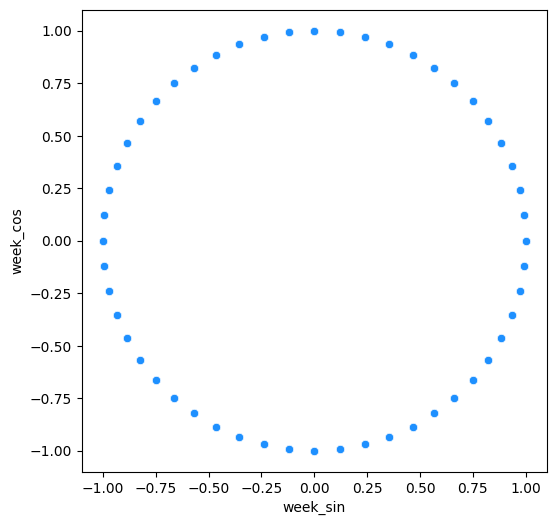

In [101]:
df_xg['week_sin'] = np.sin(2*np.pi*df_xg['week']/52)
df_xg['week_cos'] = np.cos(2*np.pi*df_xg['week']/52)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.scatterplot(x=df_xg.week_sin, y=df_xg.week_cos, color='dodgerblue')
plt.show()

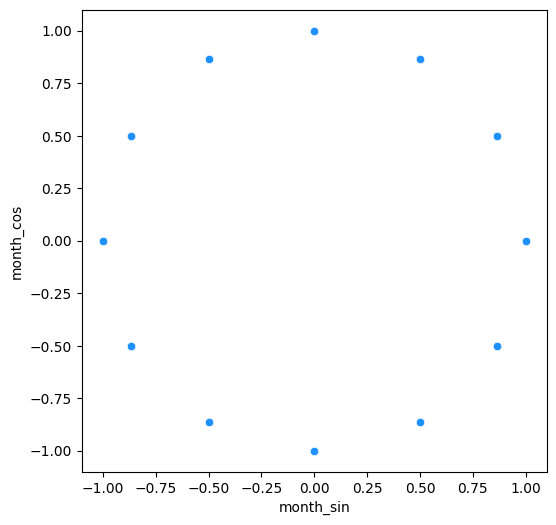

In [102]:
df_xg['month_sin'] = np.sin(2*np.pi*df_xg['month']/12)
df_xg['month_cos'] = np.cos(2*np.pi*df_xg['month']/12)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.scatterplot(x=df_xg.month_sin, y=df_xg.month_cos, color='dodgerblue')
plt.show()

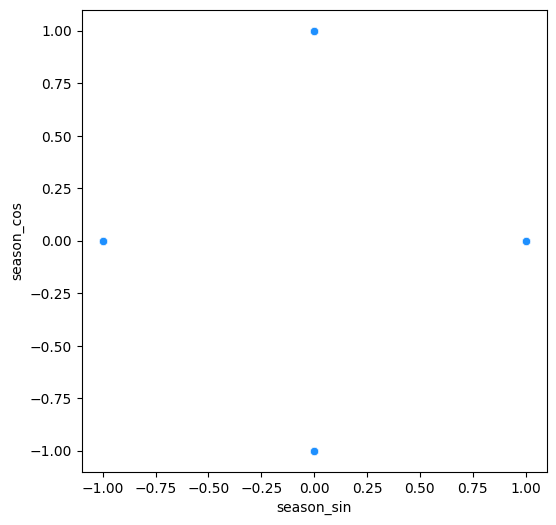

In [103]:
df_xg['season_sin'] = np.sin(2*np.pi*df_xg['season']/4)
df_xg['season_cos'] = np.cos(2*np.pi*df_xg['season']/4)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.scatterplot(x=df_xg.season_sin, y=df_xg.season_cos, color='dodgerblue')
plt.show()

In [104]:
df_xg = df_xg.drop(columns={'ds', 'day', 'month', 'week', 'season','day_of_year'})
df_xg

year  residuals       day_sin   day_cos  week_sin  week_cos  \
0     2013  -1.741082  1.721336e-02  0.999852  0.120537  0.992709   
1     2013  -4.477047  3.442161e-02  0.999407  0.120537  0.992709   
2     2013  -4.670250  5.161967e-02  0.998667  0.120537  0.992709   
3     2013  -3.182896  6.880243e-02  0.997630  0.120537  0.992709   
4     2013  -5.816476  8.596480e-02  0.996298  0.120537  0.992709   
...    ...        ...           ...       ...       ...       ...   
1457  2016   2.425625 -3.442161e-02  0.999407       0.0       1.0   
1458  2016   0.576659 -1.721336e-02  0.999852       0.0       1.0   
1459  2016  -0.496896  6.432491e-16  1.000000       0.0       1.0   
1460  2016   0.566548  1.721336e-02  0.999852       0.0       1.0   
1461  2017  -4.369535  1.721336e-02  0.999852       0.0       1.0   

         month_sin  month_cos  season_sin    season_cos  
0     5.000000e-01   0.866025        -1.0 -1.836970e-16  
1     5.000000e-01   0.866025        -1.0 -1.836970e-16  
2     5.000000e-01   0.866025        -1.0 -1.836970e-16  
3     5.000000e-01   0.866025        -1.0 -1.836970e-16  
4     5.000000e-01   0.866025        -1.0 -1.836970e-16  
...            ...        ...         ...           ...  
1457 -2.449294e-16   1.000000        -1.0 -1.836970e-16  
1458 -2.449294e-16   1.000000        -1.0 -1.836970e-16  
1459 -2.449294e-16   1.000000        -1.0 -1.836970e-16  
1460 -2.449294e-16   1.000000        -1.0 -1.836970e-16  
1461  5.000000e-01   0.866025        -1.0 -1.836970e-16  

[1462 rows x 10 columns]

In [105]:
def create_sequences(data, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(data)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(data):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = data[i:end_ix, :], data[end_ix:out_end_ix, 1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [106]:
data = df_xg.values
n_steps_in = 365
n_steps_out = 1
X_train, y_train = create_sequences(data, n_steps_in, n_steps_out)

In [107]:
X_train.shape

(1097, 365, 10)

In [108]:
y_train.shape

(1097, 1)

In [109]:
X_train_reshaped = X_train.reshape(1097, -1) 

In [110]:
X_train_reshaped.shape

(1097, 3650)

In [111]:
import xgboost as xgb

# Create the DMatrix data format from the numpy array, which is optimized for XGBoost.
dtrain = xgb.DMatrix(X_train_reshaped, label=y_train)

# Specify model parameters
params = {
    'max_depth': 3,  # Max depth of a tree, control over-fitting.
    'eta': 0.1,      # The learning rate.
    'objective': 'reg:squarederror',  # Regression with squared loss.
    'eval_metric': 'rmse'  # Root Mean Square Error as the evaluation metric
}

# Train the model
num_round = 100  # Number of boosting rounds
bst = xgb.train(params, dtrain, num_round)

It requires a little bit more work to construct a proper test set. We will predict the next day's mean_temp according to 365 previous days, and append this prediction to the data, and then predict the the day after based on 365 previous days (including what we have predicted).

In [112]:
columns = []
df_test_xg = df_test[columns]
df_test_xg

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]

[114 rows x 0 columns]

In [113]:
n = len(df_test)
df_test_xg['year'] = df_xg['year'][:n]
df_test_xg['day_sin'] = df_xg['day_sin'][:n]
df_test_xg['day_cos'] = df_xg['day_cos'][:n]
df_test_xg['week_sin'] = df_xg['week_sin'][:n]
df_test_xg['week_cos'] = df_xg['week_cos'][:n]
df_test_xg['month_sin'] = df_xg['month_sin'][:n]
df_test_xg['month_cos'] = df_xg['month_cos'][:n]
df_test_xg['season_sin'] = df_xg['season_sin'][:n]
df_test_xg['season_cos'] = df_xg['season_cos'][:n]
df_test_xg

/var/folders/rt/q1nqm7vd4j175p7gyf5tqnhh0000gn/T/ipykernel_9387/4222414591.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_xg['year'] = df_xg['year'][:n]
/var/folders/rt/q1nqm7vd4j175p7gyf5tqnhh0000gn/T/ipykernel_9387/4222414591.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_xg['day_sin'] = df_xg['day_sin'][:n]
/var/folders/rt/q1nqm7vd4j175p7gyf5tqnhh0000gn/T/ipykernel_9387/4222414591.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

year   day_sin   day_cos  week_sin  week_cos  month_sin  month_cos  \
0    2013  0.017213  0.999852  0.120537  0.992709   0.500000   0.866025   
1    2013  0.034422  0.999407  0.120537  0.992709   0.500000   0.866025   
2    2013  0.051620  0.998667  0.120537  0.992709   0.500000   0.866025   
3    2013  0.068802  0.997630  0.120537  0.992709   0.500000   0.866025   
4    2013  0.085965  0.996298  0.120537  0.992709   0.500000   0.866025   
..    ...       ...       ...       ...       ...        ...        ...   
109  2013  0.948362 -0.317191  0.935016 -0.354605   0.866025  -0.500000   
110  2013  0.942761 -0.333469  0.935016 -0.354605   0.866025  -0.500000   
111  2013  0.936881 -0.349647  0.885456 -0.464723   0.866025  -0.500000   
112  2013  0.930724 -0.365723  0.885456 -0.464723   0.866025  -0.500000   
113  2013  0.924291 -0.381689  0.885456 -0.464723   0.866025  -0.500000   

     season_sin    season_cos  
0          -1.0 -1.836970e-16  
1          -1.0 -1.836970e-16  
2          -1.0 -1.836970e-16  
3          -1.0 -1.836970e-16  
4          -1.0 -1.836970e-16  
..          ...           ...  
109         0.0  1.000000e+00  
110         0.0  1.000000e+00  
111         0.0  1.000000e+00  
112         0.0  1.000000e+00  
113         0.0  1.000000e+00  

[114 rows x 9 columns]

In [114]:
# Take the last 365 days from input_days then predict and return
def process_current(input_days, index):
    X = input_days[-365:]
    # X should be of shape (1, 3650)
    X = X.reshape(1,-1)
    dtest = xgb.DMatrix(X)
    y_pred = bst.predict(dtest)[0]
    y = np.zeros(10)
    y[0] = df_test_xg['year'][index]
    y[1] = y_pred
    y[2] = df_test_xg['day_sin'][index]
    y[3] = df_test_xg['day_cos'][index]
    y[4] = df_test_xg['week_sin'][index]
    y[5] = df_test_xg['week_cos'][index]
    y[6] = df_test_xg['month_sin'][index]
    y[7] = df_test_xg['month_cos'][index]
    y[8] = df_test_xg['season_sin'][index]
    y[9] = df_test_xg['season_cos'][index]
    return y.reshape(1,-1)

In [115]:
X_init = X_train[-1]
X_init.shape

(365, 10)

In [116]:
input_days = X_init
predictions = []
for i in range(len(df_test)):
    y = process_current(input_days, i)
    # Append y[1] to the prediction
    predictions.append(y[0][1])
    # Append y to input_days and use it to predict the next day
    input_days = np.vstack((input_days, y))

In [117]:
predictions = np.array(predictions)
predictions.shape

(114,)

In [118]:
# RMSE for df_test
# Note that y_prediction = y_pred (from Prophet) + predictions (errors from XG Boost)
y_prediction = predictions + y_pred
y_true = df_test['mean_temp'].values
rmse = np.sqrt(mean_squared_error(y_true, y_prediction))

print(f'RMSE: {rmse}')

RMSE: 2.79525057035658


We can see that the RMSE los decreases.

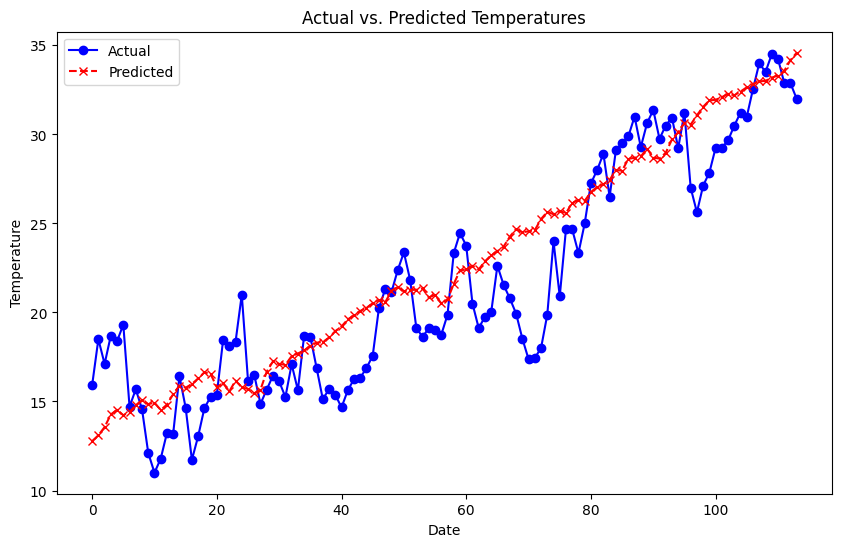

In [119]:
# Plot for df_test
plt.figure(figsize=(10, 6))
plt.plot(y_true, label='Actual', color='blue', marker='o')
plt.plot(y_prediction.values, label='Predicted', color='red', linestyle='--', marker='x')
plt.title('Actual vs. Predicted Temperatures')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

<Axes: xlabel='yhat', ylabel='Count'>

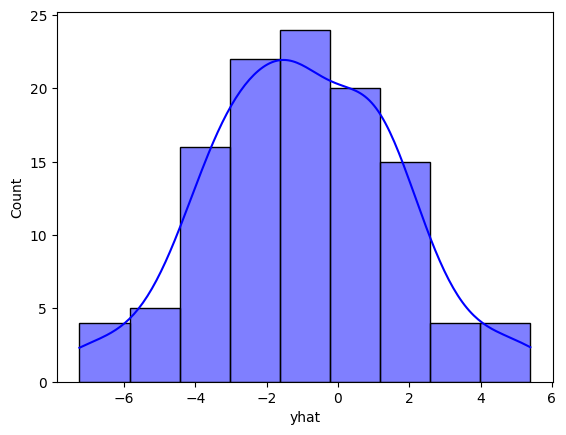

In [120]:
# Residuals distribution
residuals = y_true - y_prediction
sns.histplot(
    data=residuals,
    kde=True,
    color='blue'
)

***Compared to the residuals of Prophet model alone***

- The histogram is more centered around zero, which suggests that the combined model is, on average, more accurate, with less bias in the forecasts.
- There is a noticeable improvement in the distribution of residuals, with fewer instances of large errors as compared to the Prophet-only model.
- The distribution appears to be more symmetric, indicating that the positive and negative errors are more balanced.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


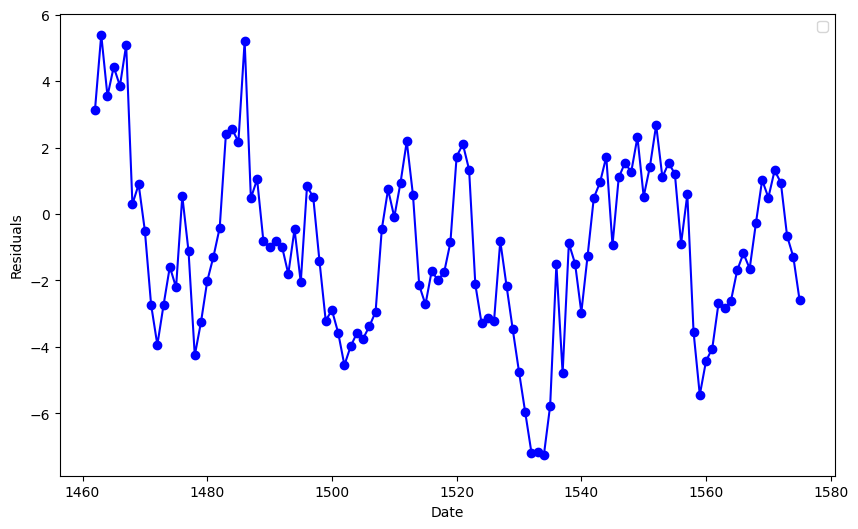

In [121]:
# Residuals plot
plt.figure(figsize=(10, 6))
plt.plot(residuals, color='blue', marker='o')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()

<a id="differencing-the-series" ></a>
# Differencing the series

Because mean_temperature is not stationary, we can try differencing it and see if the result is improved.

In [122]:
df_train_reset

ds          y    humidity  wind_speed  mean_pressure  day  week  \
0    2013-01-01  10.000000   84.500000    0.000000    1015.666667    1     1   
1    2013-01-02   7.400000   92.000000    2.980000    1017.800000    2     1   
2    2013-01-03   7.166667   87.000000    4.633333    1018.666667    3     1   
3    2013-01-04   8.666667   71.333333    1.233333    1017.166667    4     1   
4    2013-01-05   6.000000   86.833333    3.700000    1016.500000    5     1   
...         ...        ...         ...         ...            ...  ...   ...   
1457 2016-12-28  17.217391   68.043478    3.547826    1015.565217   28    52   
1458 2016-12-29  15.238095   87.857143    6.000000    1016.904762   29    52   
1459 2016-12-30  14.095238   89.666667    6.266667    1017.904762   30    52   
1460 2016-12-31  15.052632   87.000000    7.325000    1016.100000   31    52   
1461 2017-01-01  10.000000  100.000000    0.000000    1016.000000    1    52   

      month  year  season  
0         1  2013       3  
1         1  2013       3  
2         1  2013       3  
3         1  2013       3  
4         1  2013       3  
...     ...   ...     ...  
1457     12  2016       3  
1458     12  2016       3  
1459     12  2016       3  
1460     12  2016       3  
1461      1  2017       3  

[1462 rows x 10 columns]

In [123]:
columns = ['ds', 'y']
# Calculate the difference
df_diff = df_train_reset[columns]
df_diff

ds          y
0    2013-01-01  10.000000
1    2013-01-02   7.400000
2    2013-01-03   7.166667
3    2013-01-04   8.666667
4    2013-01-05   6.000000
...         ...        ...
1457 2016-12-28  17.217391
1458 2016-12-29  15.238095
1459 2016-12-30  14.095238
1460 2016-12-31  15.052632
1461 2017-01-01  10.000000

[1462 rows x 2 columns]

In [124]:
# Calculate the difference
df_diff['y_diff'] = df_diff['y'].diff()

/var/folders/rt/q1nqm7vd4j175p7gyf5tqnhh0000gn/T/ipykernel_9387/3686518207.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diff['y_diff'] = df_diff['y'].diff()


In [125]:
df_diff = df_diff.dropna(subset=['y_diff'])

In [126]:
df_diff

ds          y    y_diff
1    2013-01-02   7.400000 -2.600000
2    2013-01-03   7.166667 -0.233333
3    2013-01-04   8.666667  1.500000
4    2013-01-05   6.000000 -2.666667
5    2013-01-06   7.000000  1.000000
...         ...        ...       ...
1457 2016-12-28  17.217391  0.367391
1458 2016-12-29  15.238095 -1.979296
1459 2016-12-30  14.095238 -1.142857
1460 2016-12-31  15.052632  0.957393
1461 2017-01-01  10.000000 -5.052632

[1461 rows x 3 columns]

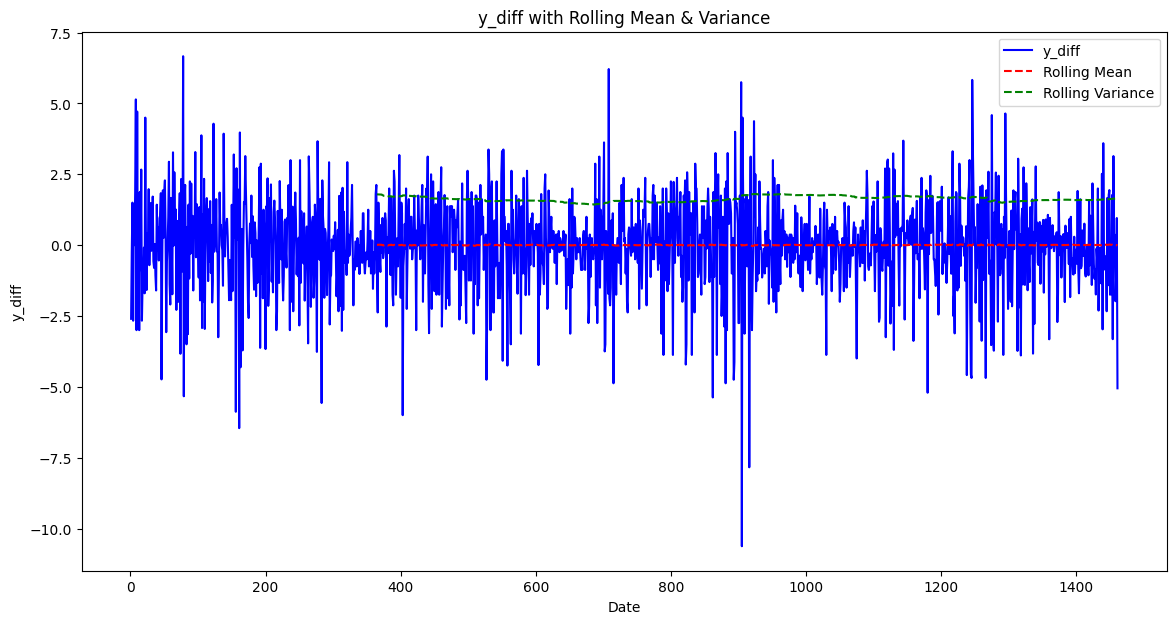

In [127]:
# Check stationary for y_diff
rolling_mean = df_diff['y_diff'].rolling(window=365).mean()
rolling_var = df_diff['y_diff'].rolling(window=365).std()

# Plotting the time series along with the rolling statistics
plt.figure(figsize=(14, 7))
plt.plot(df_diff['y_diff'], label='y_diff', color='blue')
plt.plot(rolling_mean, label='Rolling Mean', color='red', linestyle='--')
plt.plot(rolling_var, label='Rolling Variance', color='green', linestyle='--')
plt.title('y_diff with Rolling Mean & Variance')
plt.xlabel('Date')
plt.ylabel('y_diff')
plt.legend()
plt.show()

In [128]:
# ADF test
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_diff['y_diff'].values)
result

(-16.37872026707473,
 2.764863137594288e-29,
 9,
 1451,
 {'1%': -3.4348647527922824,
  '5%': -2.863533960720434,
  '10%': -2.567831568508802},
 5423.097584257939)

The ADF test results show that mean_temp is now stationary after differencing.

In [129]:
df_diff = df_diff.rename(columns={'y': 'mean_temp', 'y_diff': 'y'})

In [130]:
m = Prophet()

In [131]:
m.fit(df_diff)

16:21:02 - cmdstanpy - INFO - Chain [1] start processing
16:21:02 - cmdstanpy - INFO - Chain [1] done processing


In [132]:
future = m.make_future_dataframe(periods=len(df_test)) # Adjust periods as needed
forecast = m.predict(future)

In [133]:
forecast

ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0    2013-01-02  0.024461   -1.946100    2.323227     0.024461     0.024461   
1    2013-01-03  0.024429   -2.155350    1.996873     0.024429     0.024429   
2    2013-01-04  0.024396   -2.156556    2.037739     0.024396     0.024396   
3    2013-01-05  0.024363   -1.985593    2.136817     0.024363     0.024363   
4    2013-01-06  0.024330   -2.300170    1.979688     0.024330     0.024330   
...         ...       ...         ...         ...          ...          ...   
1570 2017-04-21 -0.026855   -2.048453    2.050836    -0.026855    -0.026855   
1571 2017-04-22 -0.026888   -2.086608    2.232299    -0.026888    -0.026888   
1572 2017-04-23 -0.026921   -2.020394    2.179697    -0.026921    -0.026920   
1573 2017-04-24 -0.026953   -1.942842    2.440105    -0.026953    -0.026953   
1574 2017-04-25 -0.026986   -1.731171    2.449963    -0.026986    -0.026986   

      additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
0           0.100635              0.100635              0.100635  0.113998   
1          -0.076119             -0.076119             -0.076119 -0.077298   
2          -0.023580             -0.023580             -0.023580 -0.037781   
3          -0.069116             -0.069116             -0.069116 -0.094775   
4          -0.088482             -0.088482             -0.088482 -0.124027   
...              ...                   ...                   ...       ...   
1570        0.140617              0.140617              0.140617 -0.037781   
1571        0.078240              0.078240              0.078240 -0.094775   
1572        0.043045              0.043045              0.043045 -0.124027   
1573        0.325571              0.325571              0.325571  0.164927   
1574        0.208777              0.208777              0.208777  0.054956   

      weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
0         0.113998      0.113998 -0.013363     -0.013363     -0.013363   
1        -0.077298     -0.077298  0.001179      0.001179      0.001179   
2        -0.037781     -0.037781  0.014202      0.014202      0.014202   
3        -0.094775     -0.094775  0.025659      0.025659      0.025659   
4        -0.124027     -0.124027  0.035545      0.035545      0.035545   
...            ...           ...       ...           ...           ...   
1570     -0.037781     -0.037781  0.178398      0.178398      0.178398   
1571     -0.094775     -0.094775  0.173015      0.173015      0.173015   
1572     -0.124027     -0.124027  0.167072      0.167072      0.167072   
1573      0.164927      0.164927  0.160644      0.160644      0.160644   
1574      0.054956      0.054956  0.153821      0.153821      0.153821   

      multiplicative_terms  multiplicative_terms_lower  \
0                      0.0                         0.0   
1                      0.0                         0.0   
2                      0.0                         0.0   
3                      0.0                         0.0   
4                      0.0                         0.0   
...                    ...                         ...   
1570                   0.0                         0.0   
1571                   0.0                         0.0   
1572                   0.0                         0.0   
1573                   0.0                         0.0   
1574                   0.0                         0.0   

      multiplicative_terms_upper      yhat  
0                            0.0  0.125096  
1                            0.0 -0.051691  
2                            0.0  0.000816  
3                            0.0 -0.044753  
4                            0.0 -0.064152  
...                          ...       ...  
1570                         0.0  0.113761  
1571                         0.0  0.051352  
1572                         0.0  0.016125  
1573                         0.0  0.298617  
1574                         0.0  0.181792  



In [134]:
last_actual_y = df_train_reset['y'].iloc[-1]

# 'yhat' is forecasted 'y_diff', start the reverse transformation
forecast['yhat_cumsum'] = forecast['yhat'].cumsum()

# Add the last actual 'y' to the cumulative sum to get back to original scale
forecast['yhat_original'] = last_actual_y + forecast['yhat_cumsum']

In [135]:
forecast

ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0    2013-01-02  0.024461   -1.946100    2.323227     0.024461     0.024461   
1    2013-01-03  0.024429   -2.155350    1.996873     0.024429     0.024429   
2    2013-01-04  0.024396   -2.156556    2.037739     0.024396     0.024396   
3    2013-01-05  0.024363   -1.985593    2.136817     0.024363     0.024363   
4    2013-01-06  0.024330   -2.300170    1.979688     0.024330     0.024330   
...         ...       ...         ...         ...          ...          ...   
1570 2017-04-21 -0.026855   -2.048453    2.050836    -0.026855    -0.026855   
1571 2017-04-22 -0.026888   -2.086608    2.232299    -0.026888    -0.026888   
1572 2017-04-23 -0.026921   -2.020394    2.179697    -0.026921    -0.026920   
1573 2017-04-24 -0.026953   -1.942842    2.440105    -0.026953    -0.026953   
1574 2017-04-25 -0.026986   -1.731171    2.449963    -0.026986    -0.026986   

      additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
0           0.100635              0.100635              0.100635  0.113998   
1          -0.076119             -0.076119             -0.076119 -0.077298   
2          -0.023580             -0.023580             -0.023580 -0.037781   
3          -0.069116             -0.069116             -0.069116 -0.094775   
4          -0.088482             -0.088482             -0.088482 -0.124027   
...              ...                   ...                   ...       ...   
1570        0.140617              0.140617              0.140617 -0.037781   
1571        0.078240              0.078240              0.078240 -0.094775   
1572        0.043045              0.043045              0.043045 -0.124027   
1573        0.325571              0.325571              0.325571  0.164927   
1574        0.208777              0.208777              0.208777  0.054956   

      ...  weekly_upper    yearly  yearly_lower  yearly_upper  \
0     ...      0.113998 -0.013363     -0.013363     -0.013363   
1     ...     -0.077298  0.001179      0.001179      0.001179   
2     ...     -0.037781  0.014202      0.014202      0.014202   
3     ...     -0.094775  0.025659      0.025659      0.025659   
4     ...     -0.124027  0.035545      0.035545      0.035545   
...   ...           ...       ...           ...           ...   
1570  ...     -0.037781  0.178398      0.178398      0.178398   
1571  ...     -0.094775  0.173015      0.173015      0.173015   
1572  ...     -0.124027  0.167072      0.167072      0.167072   
1573  ...      0.164927  0.160644      0.160644      0.160644   
1574  ...      0.054956  0.153821      0.153821      0.153821   

      multiplicative_terms  multiplicative_terms_lower  \
0                      0.0                         0.0   
1                      0.0                         0.0   
2                      0.0                         0.0   
3                      0.0                         0.0   
4                      0.0                         0.0   
...                    ...                         ...   
1570                   0.0                         0.0   
1571                   0.0                         0.0   
1572                   0.0                         0.0   
1573                   0.0                         0.0   
1574                   0.0                         0.0   

      multiplicative_terms_upper      yhat  yhat_cumsum  yhat_original  
0                            0.0  0.125096     0.125096      10.125096  
1                            0.0 -0.051691     0.073406      10.073406  
2                            0.0  0.000816     0.074222      10.074222  
3                            0.0 -0.044753     0.029468      10.029468  
4                            0.0 -0.064152    -0.034683       9.965317  
...                          ...       ...          ...            ...  
1570                         0.0  0.113761    15.619696      25.619696  
1571                         0.0  0.051352    15.671048      25.6

In [136]:
# RMSE for df_test
y_pred = forecast['yhat_original'][-len(df_test):]  # Last 'len(p_test)' predictions
y_true = df_test['mean_temp'].values

rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f'RMSE: {rmse}')

RMSE: 5.301679768258845


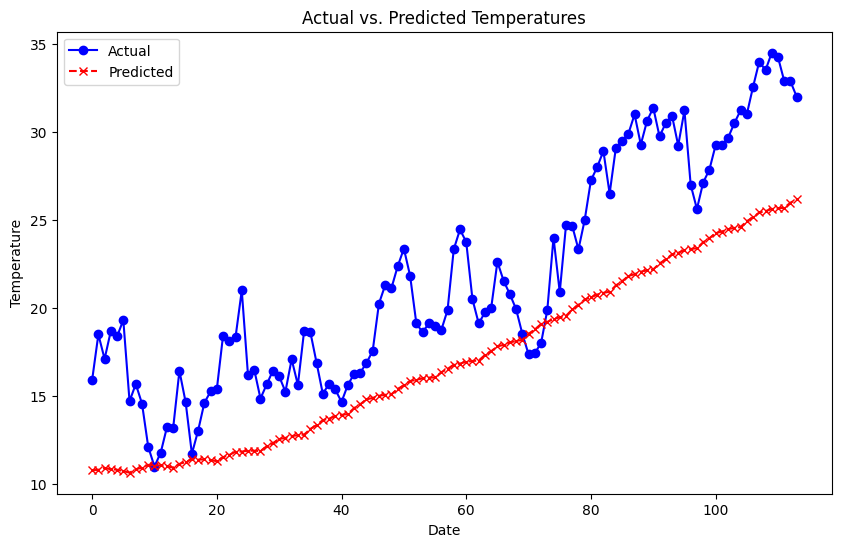

In [137]:
# Plot for df_test
plt.figure(figsize=(10, 6))
plt.plot(y_true, label='Actual', color='blue', marker='o')
plt.plot(y_pred.values, label='Predicted', color='red', linestyle='--', marker='x')
plt.title('Actual vs. Predicted Temperatures')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

<Axes: ylabel='Count'>

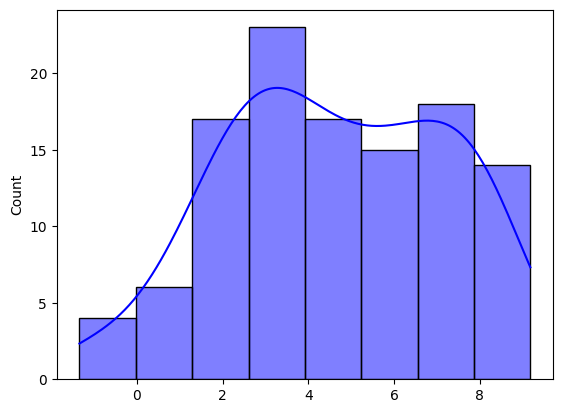

In [138]:
# Residuals distribution
residuals = y_true - y_pred.values
sns.histplot(
    data=residuals,
    kde=True,
    color='blue'
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


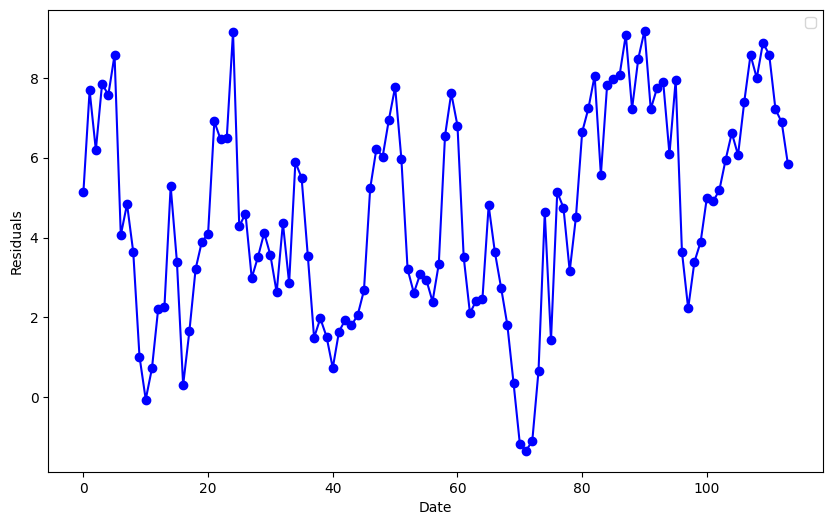

In [139]:
# Residuals plot
plt.figure(figsize=(10, 6))
plt.plot(residuals, color='blue', marker='o')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()

This is even not better than univariate approach alone. 

<a id="multivariate-approach" ></a>
# Multivariate approach 

***Wind_speed and humidity are unknown***

We will first use univariate Prophet to predict wind_speed and humidity.

In [140]:
wind_model = Prophet()

In [141]:
df_wind = df_train_reset
df_wind = df_wind.rename(columns={'y': 'mean_temperature', 'wind_speed': 'y'})
df_wind

ds  mean_temperature    humidity         y  mean_pressure  day  \
0    2013-01-01         10.000000   84.500000  0.000000    1015.666667    1   
1    2013-01-02          7.400000   92.000000  2.980000    1017.800000    2   
2    2013-01-03          7.166667   87.000000  4.633333    1018.666667    3   
3    2013-01-04          8.666667   71.333333  1.233333    1017.166667    4   
4    2013-01-05          6.000000   86.833333  3.700000    1016.500000    5   
...         ...               ...         ...       ...            ...  ...   
1457 2016-12-28         17.217391   68.043478  3.547826    1015.565217   28   
1458 2016-12-29         15.238095   87.857143  6.000000    1016.904762   29   
1459 2016-12-30         14.095238   89.666667  6.266667    1017.904762   30   
1460 2016-12-31         15.052632   87.000000  7.325000    1016.100000   31   
1461 2017-01-01         10.000000  100.000000  0.000000    1016.000000    1   

      week  month  year  season  
0        1      1  2013       3  
1        1      1  2013       3  
2        1      1  2013       3  
3        1      1  2013       3  
4        1      1  2013       3  
...    ...    ...   ...     ...  
1457    52     12  2016       3  
1458    52     12  2016       3  
1459    52     12  2016       3  
1460    52     12  2016       3  
1461    52      1  2017       3  

[1462 rows x 10 columns]

In [142]:
wind_model.fit(df_wind)

16:21:03 - cmdstanpy - INFO - Chain [1] start processing
16:21:03 - cmdstanpy - INFO - Chain [1] done processing


In [143]:
future = wind_model.make_future_dataframe(periods=len(df_test))

In [144]:
wind_forecast = wind_model.predict(future)

In [145]:
# Extract the predicted and actual values
wind_pred = wind_forecast['yhat'][-len(df_test):]  # Last 'len(p_test)' predictions
wind_true = df_test['wind_speed'].values

rmse = np.sqrt(mean_squared_error(wind_true, wind_pred))

print(f'RMSE: {rmse}')

RMSE: 3.5080572265879764


In [146]:
# To improve the accuracy for humidity, you may consider adding change point manually
#humidity_model = Prophet(changepoints=['2013-04-01', '2013-12-01', '2014-09-20', '2015-06-15', '2015-10-15', '2016-04-01'])

In [147]:
# Or increase the changepoint_prior_scale
# humidity_model = Prophet(changepoint_prior_scale=0.5)

In [148]:
humidity_model = Prophet()

In [149]:
df_humidity = df_train_reset
df_humidity = df_humidity.rename(columns={'y': 'mean_temperature', 'humidity': 'y'})
df_humidity

ds  mean_temperature           y  wind_speed  mean_pressure  day  \
0    2013-01-01         10.000000   84.500000    0.000000    1015.666667    1   
1    2013-01-02          7.400000   92.000000    2.980000    1017.800000    2   
2    2013-01-03          7.166667   87.000000    4.633333    1018.666667    3   
3    2013-01-04          8.666667   71.333333    1.233333    1017.166667    4   
4    2013-01-05          6.000000   86.833333    3.700000    1016.500000    5   
...         ...               ...         ...         ...            ...  ...   
1457 2016-12-28         17.217391   68.043478    3.547826    1015.565217   28   
1458 2016-12-29         15.238095   87.857143    6.000000    1016.904762   29   
1459 2016-12-30         14.095238   89.666667    6.266667    1017.904762   30   
1460 2016-12-31         15.052632   87.000000    7.325000    1016.100000   31   
1461 2017-01-01         10.000000  100.000000    0.000000    1016.000000    1   

      week  month  year  season  
0        1      1  2013       3  
1        1      1  2013       3  
2        1      1  2013       3  
3        1      1  2013       3  
4        1      1  2013       3  
...    ...    ...   ...     ...  
1457    52     12  2016       3  
1458    52     12  2016       3  
1459    52     12  2016       3  
1460    52     12  2016       3  
1461    52      1  2017       3  

[1462 rows x 10 columns]

In [150]:
humidity_model.fit(df_humidity)

16:21:04 - cmdstanpy - INFO - Chain [1] start processing
16:21:04 - cmdstanpy - INFO - Chain [1] done processing


In [151]:
future = humidity_model.make_future_dataframe(periods=len(df_test))

In [152]:
humidity_forecast = humidity_model.predict(future)

In [153]:
# Extract the predicted and actual values
humidity_pred = humidity_forecast['yhat'][-len(df_test):]  # Last 'len(p_test)' predictions
humidity_true = df_test['humidity'].values

rmse = np.sqrt(mean_squared_error(humidity_true, humidity_pred))

print(f'RMSE: {rmse}')

RMSE: 10.079785348643103


In [154]:
humidity_forecast

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0    2013-01-01  57.905300   62.373208   87.171329    57.905300    57.905300   
1    2013-01-02  57.933616   61.616098   86.656140    57.933616    57.933616   
2    2013-01-03  57.961932   61.373826   87.923233    57.961932    57.961932   
3    2013-01-04  57.990248   62.516824   88.971018    57.990248    57.990248   
4    2013-01-05  58.018564   64.327519   90.889491    58.018564    58.018564   
...         ...        ...         ...         ...          ...          ...   
1571 2017-04-21  58.447372   19.181054   44.976292    58.073670    58.875535   
1572 2017-04-22  58.444820   20.014920   46.355146    58.064348    58.877259   
1573 2017-04-23  58.442268   20.242300   46.881736    58.055241    58.878982   
1574 2017-04-24  58.439717   18.905166   43.726299    58.047611    58.879939   
1575 2017-04-25  58.437165   18.683934   44.561892    58.037689    58.882308   

      additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
0          16.939759             16.939759             16.939759 -0.262787   
1          16.830182             16.830182             16.830182 -0.730133   
2          16.829746             16.829746             16.829746 -1.095123   
3          18.115924             18.115924             18.115924 -0.173844   
4          19.886770             19.886770             19.886770  1.238965   
...              ...                   ...                   ...       ...   
1571      -26.563466            -26.563466            -26.563466 -0.173844   
1572      -25.350327            -25.350327            -25.350327  1.238965   
1573      -25.577170            -25.577170            -25.577170  1.141927   
1574      -26.903231            -26.903231            -26.903231 -0.119005   
1575      -27.053626            -27.053626            -27.053626 -0.262787   

      weekly_lower  weekly_upper     yearly  yearly_lower  yearly_upper  \
0        -0.262787     -0.262787  17.202545     17.202545     17.202545   
1        -0.730133     -0.730133  17.560315     17.560315     17.560315   
2        -1.095123     -1.095123  17.924869     17.924869     17.924869   
3        -0.173844     -0.173844  18.289768     18.289768     18.289768   
4         1.238965      1.238965  18.647806     18.647806     18.647806   
...            ...           ...        ...           ...           ...   
1571     -0.173844     -0.173844 -26.389622    -26.389622    -26.389622   
1572      1.238965      1.238965 -26.589292    -26.589292    -26.589292   
1573      1.141927      1.141927 -26.719098    -26.719098    -26.719098   
1574     -0.119005     -0.119005 -26.784226    -26.784226    -26.784226   
1575     -0.262787     -0.262787 -26.790839    -26.790839    -26.790839   

      multiplicative_terms  multiplicative_terms_lower  \
0                      0.0                         0.0   
1                      0.0                         0.0   
2                      0.0                         0.0   
3                      0.0                         0.0   
4                      0.0                         0.0   
...                    ...                         ...   
1571                   0.0                         0.0   
1572                   0.0                         0.0   
1573                   0.0                         0.0   
1574                   0.0                         0.0   
1575                   0.0                         0.0   

      multiplicative_terms_upper       yhat  
0                            0.0  74.845059  
1                            0.0  74.763798  
2                            0.0  74.791678  
3                            0.0  76.106172  
4                            0.0  77.905334  
...                          ...        ...  
1571                         0.0  31.883906  
1572                         0.0  33.094493  
1573                         0.0  32.865098  
1574                         0.0  31.536485  
1575       

/Users/khanhdam/.local/share/virtualenvs/TimeSeries_StackingModels-SOMotZfp/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/khanhdam/.local/share/virtualenvs/TimeSeries_StackingModels-SOMotZfp/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


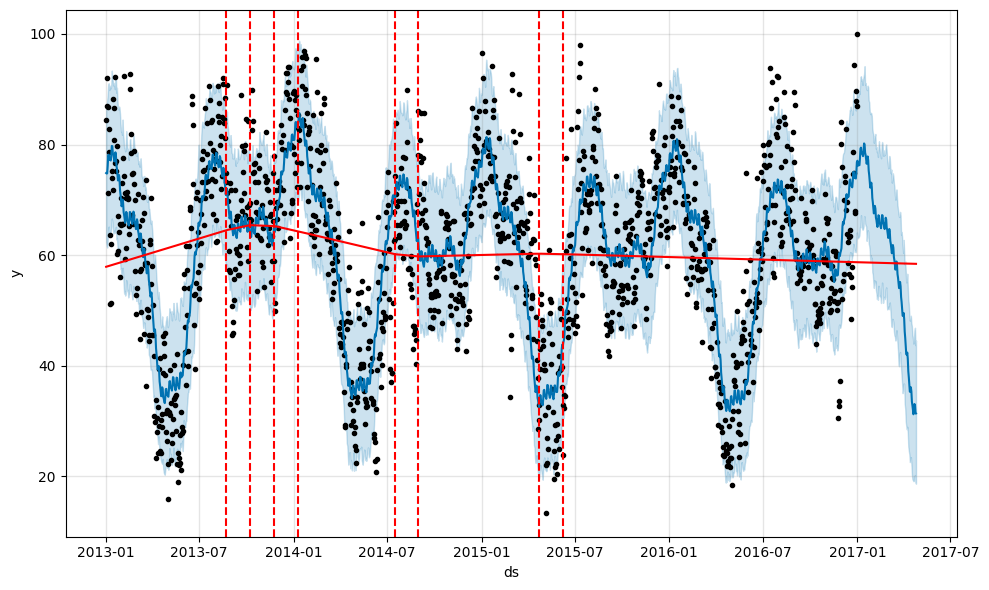

In [155]:
# Trend plot for humidity
from prophet.plot import add_changepoints_to_plot
fig = humidity_model.plot(humidity_forecast)
# Add change points to the plot
a = add_changepoints_to_plot(fig.gca(), humidity_model, humidity_forecast)

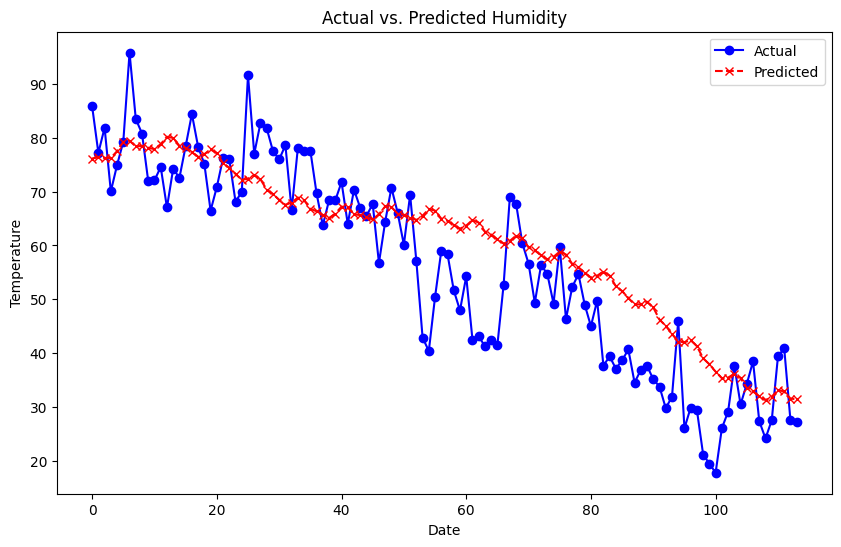

In [156]:
# Humidity prediction plot
humidity_pred = humidity_pred.values
plt.figure(figsize=(10, 6))
plt.plot(humidity_true, label='Actual', color='blue', marker='o')
plt.plot(humidity_pred, label='Predicted', color='red', linestyle='--', marker='x')
plt.title('Actual vs. Predicted Humidity')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

After predicting humidity and wind_speed, we are now ready to predict mean_temp.

In [157]:
model = Prophet()

In [158]:
model.add_regressor('wind_speed')
model.add_regressor('humidity')

In [159]:
model.fit(df_train_reset)

16:21:05 - cmdstanpy - INFO - Chain [1] start processing
16:21:05 - cmdstanpy - INFO - Chain [1] done processing


In [160]:
future = model.make_future_dataframe(periods=len(df_test))

In [161]:
future['wind_speed'] = wind_forecast['yhat']
future['humidity'] = humidity_forecast['yhat']

In [162]:
forecast = model.predict(future)

In [163]:
# Extract the predicted and actual values
y_pred = forecast['yhat'][-len(df_test):]  # Last 'len(p_test)' predictions
y_true = df_test['mean_temp'].values

rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f'RMSE: {rmse}')

RMSE: 2.8070843455689123


In [164]:
y_pred.values

array([14.67898727, 14.77209252, 14.94410303, 14.93587784, 14.97615107,
       14.96644719, 14.93258728, 15.21303441, 15.35689633, 15.56709451,
       15.5854324 , 15.64183364, 15.63921654, 15.60495519, 15.87917667,
       16.01271387, 16.21022439, 16.21520973, 16.25920686, 16.24661969,
       16.20614194, 16.4790218 , 16.61698879, 16.82535367, 16.84801626,
       16.91665315, 16.93555303, 16.93305062, 17.24980934, 17.43677231,
       17.69829181, 17.77717102, 17.90388902, 17.98147558, 18.03698551,
       18.40982162, 18.64972448, 18.95993833, 19.08228554, 19.24642004,
       19.35472527, 19.43380595, 19.82282219, 20.0714841 , 20.38321589,
       20.50022239, 20.65272852, 20.74385777, 20.80109983, 21.1646165 ,
       21.38520502, 21.6674289 , 21.75464998, 21.87823352, 21.94239331,
       21.97562794, 22.31899827, 22.52406604, 22.79600447, 22.87861498,
       23.00352239, 23.07501561, 23.12148516, 23.48370742, 23.71279517,
       24.0133249 , 24.12837439, 24.28874226, 24.3978157 , 24.48

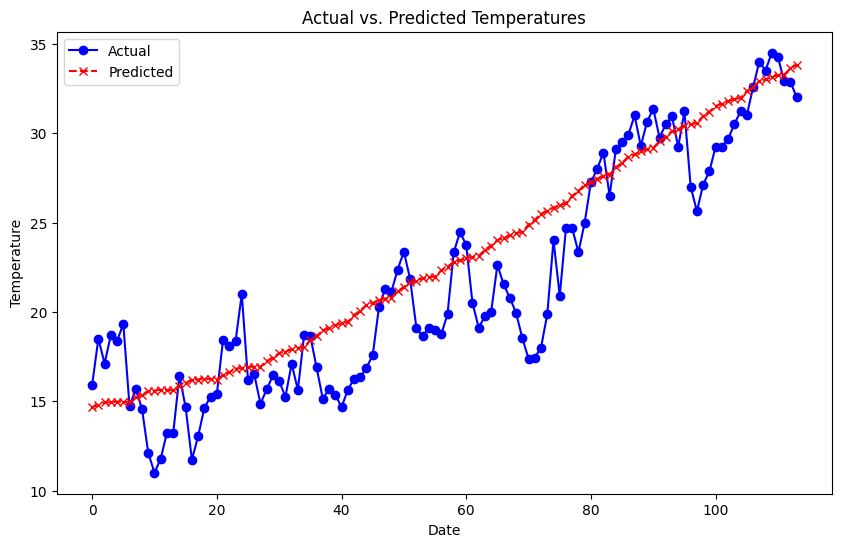

In [165]:
plt.figure(figsize=(10, 6))
plt.plot(y_true, label='Actual', color='blue', marker='o')
plt.plot(y_pred.values, label='Predicted', color='red', linestyle='--', marker='x')
plt.title('Actual vs. Predicted Temperatures')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()


<Axes: ylabel='Count'>

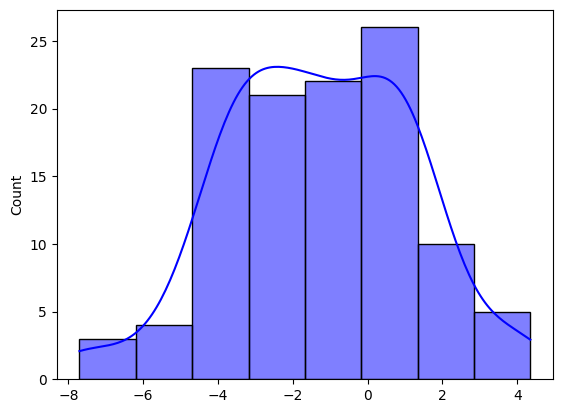

In [166]:
# Residuals distribution
residuals = y_true - y_pred.values
sns.histplot(
    data=residuals,
    kde=True,
    color='blue'
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


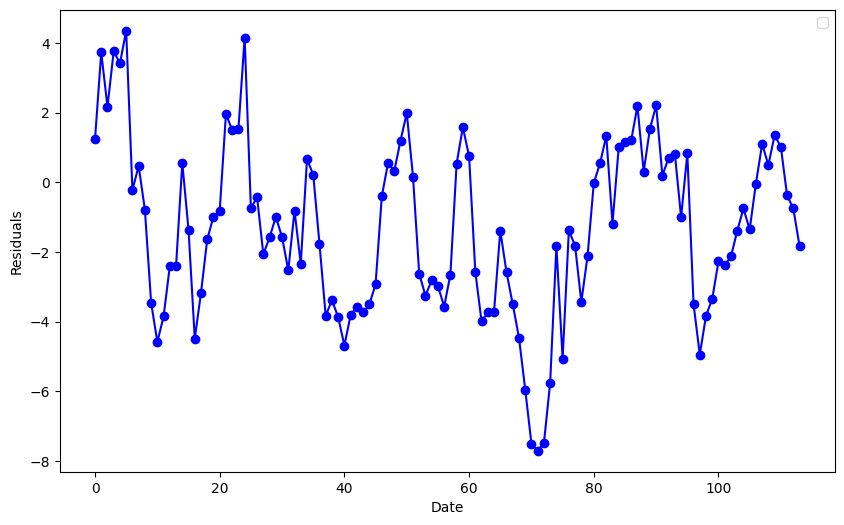

In [167]:
# Residuals plot
plt.figure(figsize=(10, 6))
plt.plot(residuals, color='blue', marker='o')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()

Here, I think we can improve by using ensemble method for predicting humidity.

<a id="vecm" ></a>
# Vector Error Correction Model (VECM)

In [168]:
columns = ['mean_temp', 'humidity', 'wind_speed']
df = df_train[columns]
df

mean_temp    humidity  wind_speed
date                                         
2013-01-01  10.000000   84.500000    0.000000
2013-01-02   7.400000   92.000000    2.980000
2013-01-03   7.166667   87.000000    4.633333
2013-01-04   8.666667   71.333333    1.233333
2013-01-05   6.000000   86.833333    3.700000
...               ...         ...         ...
2016-12-28  17.217391   68.043478    3.547826
2016-12-29  15.238095   87.857143    6.000000
2016-12-30  14.095238   89.666667    6.266667
2016-12-31  15.052632   87.000000    7.325000
2017-01-01  10.000000  100.000000    0.000000

[1462 rows x 3 columns]

As we already saw, mean_temp is not stationary while both wind_speed and humidity are stationary. The Johansen test will tell us if there is a linear combination of the three time series such that it is stationary. Note that we need this condition to use VECM.

In [169]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
# det_order:
# -1: No deterministic term (no intercept or trend).
# 0: Includes an intercept (constant) term in the model. 
# This option models the data with a mean different from zero but without a trend.
# 1: Includes an intercept (constant) and a linear trend in the cointegration equations. 
# This implies the series have a trend but the cointegration equation corrects for it.
# 2: Includes an intercept and a quadratic trend. 
# This is less common and suggests a more complex trend structure.

# k_ar_diff: lag order

def johansen_test(data, det_order=1, k_ar_diff=1):
    result = coint_johansen(data, det_order, k_ar_diff)
    print(f'Trace Statistic: {result.lr1}')
    print(f'Critical Values (90%, 95%, 99%): {result.cvt}')
    print(f'Eigen Statistic: {result.lr2}')
    print(f'Critical Values for Eigen Statistic (90%, 95%, 99%): {result.cvm}')

johansen_test(df)


Trace Statistic: [524.96077609 108.998041    12.88868224]
Critical Values (90%, 95%, 99%): [[32.0645 35.0116 41.0815]
 [16.1619 18.3985 23.1485]
 [ 2.7055  3.8415  6.6349]]
Eigen Statistic: [415.96273509  96.10935876  12.88868224]
Critical Values for Eigen Statistic (90%, 95%, 99%): [[21.8731 24.2522 29.2631]
 [15.0006 17.1481 21.7465]
 [ 2.7055  3.8415  6.6349]]


The Trace statistic tests the null hypothesis of at most r cointegrating relationships against the alternative of more than r cointegrating relationships.

- The second value (108.998041) exceeds its 99% critical value (23.1485) for the hypothesis of at most one cointegrating relationship suggesting at least two cointegrating relationships.

- The third value (12.88868224) is below the 95% critical value (18.3985) but above the 90% critical value (16.1619) for the hypothesis of at most two cointegrating relationships (r$\le$2), which might suggest some ambiguity for the presence of a third cointegrating relationship, depending on the significance level chosen.


The Maximum Eigenvalue statistic tests the null hypothesis of r cointegrating relationships against the alternative of r+1 cointegrating relationships.

- The second Eigenvalue (96.10935876) also exceeds its 99% critical value (21.7465), suggesting strong evidence for at least two cointegrating relationships.

- The third Eigenvalue (12.88868224) is above the 95% critical value (6.6349) for the hypothesis of at most two cointegrating relationships (r≤2), indicating evidence for a third cointegrating relationship.



In [170]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
johansen_test = coint_johansen(df, det_order=-1, k_ar_diff=1)
cointegrating_vectors = johansen_test.evec

# Print the cointegrating vectors
print("Cointegrating vectors:")
print(cointegrating_vectors)

Cointegrating vectors:
[[ 0.06644837  0.08225042  0.02690115]
 [ 0.00254556 -0.03428826  0.00456898]
 [-0.27467483 -0.01950227  0.00321259]]


It means that 0.06 mean_temp + 0.002 humidity - 0.27 wind_speed is a stationary time series.

In [171]:
df.shape

(1462, 3)

In [172]:
from statsmodels.tsa.vector_ar.vecm import VECM

# Fit the VECM model
vecm = VECM(df, coint_rank=2, freq='D')
vecm_fit = vecm.fit()

In [173]:
# Summary of the model
print(vecm_fit.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation mean_temp
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
L1.mean_temp     -0.1266      0.035     -3.646      0.000      -0.195      -0.059
L1.humidity       0.0037      0.007      0.523      0.601      -0.010       0.018
L1.wind_speed    -0.0213      0.011     -1.978      0.048      -0.042      -0.000
Det. terms outside the coint. relation & lagged endog. parameters for equation humidity
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
L1.mean_temp      0.8640      0.170      5.093      0.000       0.532       1.197
L1.humidity       0.0333      0.035      0.956      0.339      -0.035       0.102
L1.wind_speed    -0.0903      0.053     -1.719      0.086      -0.193       0.013
Det

In [174]:
# Forecasting
# Forecase on test set with 95% confidence
steps = len(df_test)
forecast, lower, upper = vecm_fit.predict(steps=steps, alpha=0.05) 

In [175]:
temp_pred = forecast[:, 0]
temp_true = df_test['mean_temp'].values
rmse = np.sqrt(mean_squared_error(temp_true, temp_pred))
print(rmse)

7.3718101851354865


<a id="lstm" ></a>
# LSTM

In [176]:
columns = ['mean_temp', 'humidity', 'wind_speed']
df = df_train[columns]
df

mean_temp    humidity  wind_speed
date                                         
2013-01-01  10.000000   84.500000    0.000000
2013-01-02   7.400000   92.000000    2.980000
2013-01-03   7.166667   87.000000    4.633333
2013-01-04   8.666667   71.333333    1.233333
2013-01-05   6.000000   86.833333    3.700000
...               ...         ...         ...
2016-12-28  17.217391   68.043478    3.547826
2016-12-29  15.238095   87.857143    6.000000
2016-12-30  14.095238   89.666667    6.266667
2016-12-31  15.052632   87.000000    7.325000
2017-01-01  10.000000  100.000000    0.000000

[1462 rows x 3 columns]

In [177]:
df = df.reset_index()

In [178]:
df['day_of_year'] = df['date'].dt.dayofyear

In [179]:
df['day_of_year'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

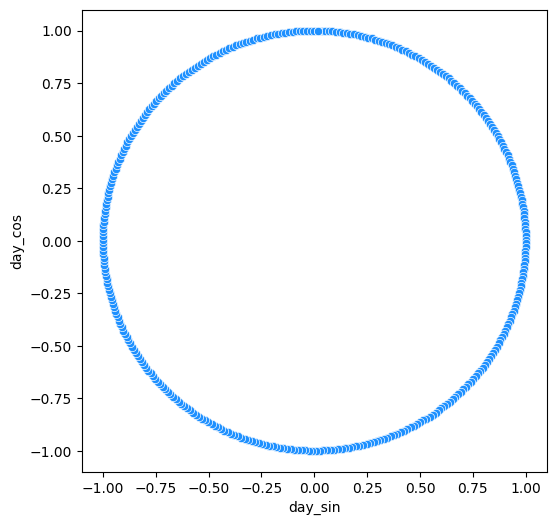

In [180]:
df['day_sin'] = np.sin(2*np.pi*df['day_of_year']/365)
df['day_cos'] = np.cos(2*np.pi*df['day_of_year']/365)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.scatterplot(x=df.day_sin, y=df.day_cos, color='dodgerblue')
plt.show()

In [181]:
df.drop(['date','day_of_year'], axis=1, inplace=True)

In [182]:
df

mean_temp    humidity  wind_speed       day_sin   day_cos
0     10.000000   84.500000    0.000000  1.721336e-02  0.999852
1      7.400000   92.000000    2.980000  3.442161e-02  0.999407
2      7.166667   87.000000    4.633333  5.161967e-02  0.998667
3      8.666667   71.333333    1.233333  6.880243e-02  0.997630
4      6.000000   86.833333    3.700000  8.596480e-02  0.996298
...         ...         ...         ...           ...       ...
1457  17.217391   68.043478    3.547826 -3.442161e-02  0.999407
1458  15.238095   87.857143    6.000000 -1.721336e-02  0.999852
1459  14.095238   89.666667    6.266667  6.432491e-16  1.000000
1460  15.052632   87.000000    7.325000  1.721336e-02  0.999852
1461  10.000000  100.000000    0.000000  1.721336e-02  0.999852

[1462 rows x 5 columns]

In [183]:
def create_sequences(data, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(data)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(data):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = data[i:end_ix, :], data[end_ix:out_end_ix, 0]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [184]:
data = df.values
n_steps_in = 365
n_steps_out = len(df_test)
X_train, y_train = create_sequences(data, n_steps_in, n_steps_out)

In [185]:
print(X_train.shape)
print(y_train.shape)

(984, 365, 5)
(984, 114)


In [186]:
# Remember to turn GPU on for LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.optimizers import Adam


num_features = 5  
num_time_steps = 365
num_predictions = 114
optimizer = Adam(learning_rate=0.0003)

# Define the model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(num_time_steps, num_features)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(32, activation='relu'))
model.add(Dense(num_predictions))  
model.compile(optimizer=optimizer, loss='mse')

# Fit model
model.fit(X_train, y_train, epochs=100, validation_split=0.2)

Epoch 1/100
25/25 [==============================] - 8s 280ms/step - loss: 692.5981 - val_loss: 963.2916
Epoch 2/100
25/25 [==============================] - 7s 265ms/step - loss: 674.5591 - val_loss: 931.6020
Epoch 3/100
25/25 [==============================] - 7s 261ms/step - loss: 639.4725 - val_loss: 875.6022
Epoch 4/100
25/25 [==============================] - 6s 258ms/step - loss: 588.6808 - val_loss: 805.7792
Epoch 5/100
25/25 [==============================] - 6s 260ms/step - loss: 527.5352 - val_loss: 721.9380
Epoch 6/100
25/25 [==============================] - 6s 258ms/step - loss: 457.6212 - val_loss: 627.7448
Epoch 7/100
25/25 [==============================] - 6s 255ms/step - loss: 383.2186 - val_loss: 529.3854
Epoch 8/100
25/25 [==============================] - 6s 257ms/step - loss: 310.3175 - val_loss: 434.4459
Epoch 9/100
25/25 [==============================] - 7s 262ms/step - loss: 244.6569 - val_loss: 346.7697
Epoch 10/100
25/25 [==============================] - 6

In [187]:
# Calculate MSE for training data
y = model.predict(X_train)
mse = mean_squared_error(y_train, y) 
rmse = sqrt(mse)

print("RMSE:", rmse)

31/31 [==============================] - 3s 73ms/step
RMSE: 2.6738194314925128


In [188]:
X_test = data[-365:]

In [189]:
X_test.shape

(365, 5)

In [190]:
X_test = X_test.reshape(1, 365, 5)

In [191]:
y_pred = model.predict(X_test)

1/1 [==============================] - 0s 40ms/step


In [192]:
y_pred.shape

(1, 114)

In [193]:
y_test = df_test['mean_temp'].values.reshape(1,-1)
y_test.shape

(1, 114)

In [194]:
mse = mean_squared_error(y_test, y_pred) 
rmse = sqrt(mse)

print("RMSE:", rmse)

RMSE: 4.461140720130553


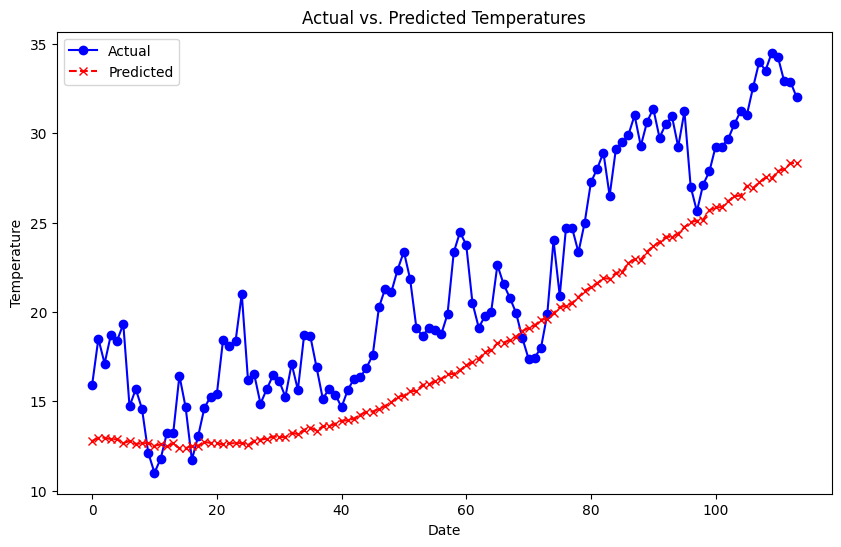

In [195]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.reshape(-1,1), label='Actual', color='blue', marker='o')
plt.plot(y_pred.reshape(-1,1), label='Predicted', color='red', linestyle='--', marker='x')
plt.title('Actual vs. Predicted Temperatures')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

<a id="neural-prophet" ></a>
# Neural Prophet

In [196]:
columns = ['ds', 'y']
df_train_neural = df_train_reset[columns]

In [197]:
df_train_neural

ds          y
0    2013-01-01  10.000000
1    2013-01-02   7.400000
2    2013-01-03   7.166667
3    2013-01-04   8.666667
4    2013-01-05   6.000000
...         ...        ...
1457 2016-12-28  17.217391
1458 2016-12-29  15.238095
1459 2016-12-30  14.095238
1460 2016-12-31  15.052632
1461 2017-01-01  10.000000

[1462 rows x 2 columns]

In [198]:
from neuralprophet import NeuralProphet

# Initialize the model
m = NeuralProphet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
)

# Fit the model
metrics = m.fit(df_train_neural, freq="D")

# Create future dataframe
future = m.make_future_dataframe(df_train_neural, periods=len(df_test))

# Forecast
forecast = m.predict(future)

ERROR:NP.plotly:Importing plotly failed. Interactive plots will not work.
ERROR:NP.plotly:Importing plotly failed. Interactive plots will not work.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /Users/khanhdam/.local/share/virtualenvs/TimeSeries_StackingModels-SOMotZfp/lib/python3.10/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.932% of the data.
WARNING - (py.warnings._showwarnmsg) - /Users/khanhdam/.local/share/virtualenvs/TimeSeries_StackingModels-SOM

Epoch 100: 100%|██████████| 100/100 [00:00<00:00, 1548.18it/s, loss=0.00612, v_num=0, MAE=1.570, RMSE=1.970, Loss=0.00569, RegLoss=0.000]  


WARNING - (py.warnings._showwarnmsg) - /Users/khanhdam/.local/share/virtualenvs/TimeSeries_StackingModels-SOMotZfp/lib/python3.10/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.932% of the data.
WARNING - (py.warnings._showwarnmsg) - /Users/khanhdam/.local/share/virtualenvs/TimeSeries_StackingModels-SOMotZfp/lib/python3.10/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 203.13it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


In [199]:
forecast

ds     y      yhat1      trend  season_yearly
0   2017-01-02  None  15.805572  28.007015     -12.201444
1   2017-01-03  None  15.776176  28.012255     -12.236078
2   2017-01-04  None  15.758316  28.017494     -12.259178
3   2017-01-05  None  15.752119  28.022736     -12.270617
4   2017-01-06  None  15.757741  28.027977     -12.270236
..         ...   ...        ...        ...            ...
109 2017-04-21  None  34.027390  28.578190       5.449200
110 2017-04-22  None  34.172371  28.583431       5.588940
111 2017-04-23  None  34.313931  28.588671       5.725261
112 2017-04-24  None  34.452202  28.593910       5.858292
113 2017-04-25  None  34.587166  28.599150       5.988017

[114 rows x 5 columns]

In [200]:
y_pred = forecast['yhat1'].values
y_true = df_test['mean_temp'].values

mse = mean_squared_error(y_true, y_pred)
rmse = sqrt(mse)
print(rmse)

3.54806613315067


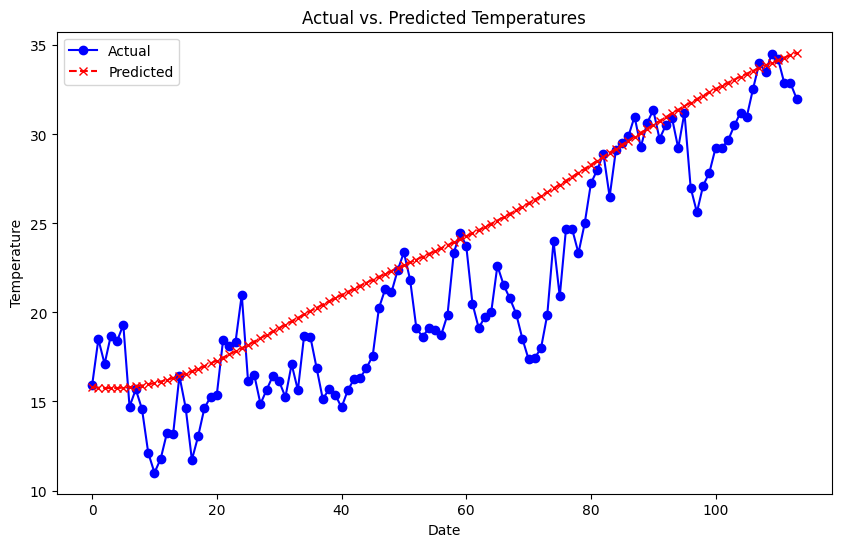

In [201]:
plt.figure(figsize=(10, 6))
plt.plot(y_true, label='Actual', color='blue', marker='o')
plt.plot(y_pred, label='Predicted', color='red', linestyle='--', marker='x')
plt.title('Actual vs. Predicted Temperatures')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

<a id="conclusion" ></a>
# Conclusion

The best model for the problem is Prophet, both multivariate (with unknown wind_speed and humidity) and univariate version perform well. When combining with XG boost on the residuals, the results for Prophet is improved. There is a reason for it:

- Prophet excels at capturing trend and seasonality, including handling holiday effects and changes in trend.

- XGBoost excels at modeling complex, nonlinear relationships and interactions between features. By focusing on the residuals, XGBoost effectively hones in on the patterns that Prophet may overlook.

LSTM and neural Prophet also perform well, but those models, especially LSTM may need more data to shine.